In [1]:
import os
import tensorflow as tf
import itertools
import numpy as np
from numpy import unravel_index
from random import choice, random, sample
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential, Model, load_model
from keras.layers import Input, BatchNormalization, Reshape
from keras.layers import Dense, Dropout, Activation, Flatten, LocallyConnected2D
from keras.layers import Conv2D, MaxPooling2D, AlphaDropout, ConvLSTM2D, AvgPool2D, Conv2DTranspose, UpSampling2D
from keras.layers import add, concatenate, multiply
from keras.initializers import VarianceScaling, RandomUniform
from keras.optimizers import Adam, SGD, rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Container
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.regularizers import l1, l2
import keras.backend as K
K.set_image_dim_ordering('th')

from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import time
%matplotlib notebook

Using TensorFlow backend.


In [11]:
class Ataxx:
    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7))   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board
            
    def get_feature_map(self, turn):
        friendly_map = (self.data == turn).astype(float)
        opponent_map = (self.data == -turn).astype(float)
        return np.concatenate((friendly_map.reshape((1, 7, 7)), opponent_map.reshape((1, 7, 7))), axis=0)
    
    def get_mask(self, turn, init=0.01):   # zero(init) out all illegal move positions
        moves = self.get_moves(turn)
        moves = list(zip(*self.get_moves(turn)))
        if len(moves) == 0:
            return np.zeros((2, 7, 7))
        else:
            start_pos = tuple(zip(*moves[0]))
            end_pos = tuple(zip(*moves[1]))
            start_mask = np.ones((7, 7)) * init
            start_mask[start_pos] = 1
            end_mask = np.ones((7, 7)) * init
            end_mask[end_pos] = 1
            return np.concatenate((start_mask.reshape((1, 7, 7)), end_mask.reshape((1, 7, 7))), axis=0)
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
                
    def is_valid(self, turn, pos):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif self.data[pos] != 0:
            return False
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    pos_tmp = (pos[0]+dr, pos[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if self.data[pos_tmp] == turn:  # convert any piece of the opponent to 'turn'
                            return True
            return False
        
    def get_moves(self, turn):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1")
        else:
            next_moves = []
            for r in range(7):
                for c in range(7):
                    has_duplicate_move = False      # move within the radius of one of another friendly piece is called
                    if self.is_valid(turn, (r, c)): # duplicate move
                        for dr in range(-2, 3):
                            for dc in range(-2, 3):
                                if abs(dr) <= 1 and abs(dc) <=1 and has_duplicate_move: 
                                    continue        # no need to record same move again
                                else:
                                    pos_tmp = (r+dr, c+dc)
                                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                                        if self.data[pos_tmp] == turn:
                                            next_moves.append((pos_tmp, (r, c)))
            return next_moves
    
    def get_greedy_move(self, turn):
        moves = self.get_moves(turn)
        if len(moves) == 0:
            raise ValueError('No Possible Moves')
        store_data = self.data.copy()
        best_score = -1000000
        for move in moves:
            self.data = store_data.copy()
            self.move_to(turn, move[0], move[1])
            score = self.evaluate(turn, -turn)
            if score > best_score:
                best_move = move
                best_score = score
        self.data = store_data
        return best_move
        
    def move_to(self, turn, pos0, pos1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[pos0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            dis = np.array(pos1) - np.array(pos0)    # check if is jump move or duplicate move
            if abs(dis[0]) > 1 or abs(dis[1]) > 1:   # jump move
                self.data[pos0] = 0
                self.data[pos1] = turn
            else:                                    # duplicate move
                self.data[pos1] = turn
            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    pos_tmp = (pos1[0]+dr, pos1[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if self.data[pos_tmp] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[pos_tmp] = turn
                            
    def simu_move_to(self, turn, pos0, pos1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[pos0] != turn:
            raise ValueError("You are not moving your piece")
        else:
            tmp_data = self.data.copy()
            dis = np.array(pos1) - np.array(pos0)    # check if is jump move or duplicate move
            if abs(dis[0]) > 1 or abs(dis[1]) > 1:   # jump move
                tmp_data[pos0] = 0
                tmp_data[pos1] = turn
            else:                                    # duplicate move
                tmp_data[pos1] = turn
            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    pos_tmp = (pos1[0]+dr, pos1[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if tmp_data[pos_tmp] == -turn:  # convert any piece of the opponent to 'turn'
                            tmp_data[pos_tmp] = turn
            return tmp_data
    
    def evaluate(self, turn, this_turn, max_score=100, min_score=0.1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        else:
            turn_no = 0
            op_no = 0
            for r in range(7):
                for c in range(7):
                    if self.data[r, c] == turn:
                        turn_no += 1
                    elif self.data[r, c] == -turn:
                        op_no += 1
            if turn_no + op_no == 49:
                if turn_no > op_no:
                    return max_score
                else:
                    return -max_score
            else:
                if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
                    if turn_no > op_no:
                        return max_score
                    else:
                        return -max_score
                else:
                    value = turn_no - op_no
            return value * min_score

In [20]:
class Relay():
    def __init__(self, max_size):
        self.relay = []
        self.max_size = max_size

    def reset(self):
        self.relay = []
        
    def add_sample(self, new_sample):
        if len(self.relay) >= self.max_size:
            self.relay.pop(0)
        self.relay.append(new_sample)
    
    def get_batch(self, batch_size):
        if len(self.relay) < batch_size:
            print('not enough sample')
            raise ValueError('relay not large enough')
        else:
            batch = sample(self.relay, batch_size)
            # generate random array to decide the orientation of the data augmentation
            is_flip = np.random.random(batch_size)
            rot_times = (np.random.random(batch_size) * 4).astype(int)
            
            cur_state = np.array([self.augmentation(item[0], is_flip[i], rot_times[i]) 
                                  for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            cur_mask = np.array([self.augmentation(item[1], is_flip[i], rot_times[i])
                                 for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            cur_action = np.array([self.augmentation(item[2], is_flip[i], rot_times[i])
                                   for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            cur_action_mask = np.array([self.augmentation(item[3], is_flip[i], rot_times[i])
                                   for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            cur_reward = np.array([item[4] for item in batch])
            try:
                new_state = np.array([self.augmentation(item[5], is_flip[i], rot_times[i])
                                      for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            except:
                new_state = np.array([self.augmentation(item[5], is_flip[i], rot_times[i])
                                      for i, item in enumerate(batch)])
            return cur_state, cur_mask, cur_action, cur_action_mask, cur_reward, new_state
    
    def augmentation(self, data, is_flip, rot_time): # data must have three dimentions and depth first
        if data is None:
            return None
        else:
            if is_flip:
                data = np.fliplr(data)
            data = np.rot90(data, k=rot_time, axes=(1, 2))
            return data
    
    def size(self):
        return len(self.relay)

# BatchNormalization helps in hard-to-tune lr situations

In [24]:
class CriticNetwork(object):
    def __init__(self, TAU=0, LEARNING_RATE=0, target_model=None, model=None):
        if target_model is None:
            self.TAU = TAU
            self.LEARNING_RATE = LEARNING_RATE

            #Now create the model
            with tf.device('/cpu'):
                self.model = self.create_critic_network() 
                self.target_model = self.create_critic_network() 
                # generate a frozen model for actor critic model stacking
                for layer in self.model.layers:
                    layer.trainable = False
                self.frozen_model = Model(inputs=self.model.inputs, outputs=self.model.outputs)
                self.frozen_model.compile(loss='mse', optimizer=Adam(lr=self.LEARNING_RATE), metrics=['mse'])
            self.gpu_model = multi_gpu_model(self.model, gpus=4)
            self.gpu_model.compile(loss='mse', optimizer=Adam(lr=self.LEARNING_RATE), metrics=['mse'])
        else:
             self.target_model = target_model
             self.model = None
        
    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self):
        board_input = Input(shape=(2, 7, 7))

        action_input = Input(shape=(2, 7, 7))
        action_mask_input = Input(shape=(2, 7, 7))
        action_one_hot = multiply(inputs=[action_input, action_mask_input])
        # stack action_input and board_features
        overall_input = concatenate(inputs=[action_one_hot, board_input], axis=1)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(overall_input)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = MaxPooling2D((2, 2))(x)
        
        x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Flatten()(x)
        
        x = Dense(512, activation='relu')(x)
        x = BatchNormalization(axis=1)(x)
        x = Dense(1)(x)
        # construct model
        model = Model(inputs=[board_input, action_input, action_mask_input], outputs=[x])
        print(model.summary())
        # sgd = SGD(lr=self.LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='mse', optimizer=Adam(lr=self.LEARNING_RATE), metrics=['mse'])
        return model
    
class ActorNetwork(object):
    def __init__(self, TAU=0, LEARNING_RATE=0, pretrain_epoch=2, is_train=True, \
                 file_name='target_actor_model.h5', target_model=None, model=None):
        if not target_model is None:
            self.target_model = target_model
            self.model = model
        elif is_train:
            self.TAU = TAU
            self.LEARNING_RATE = LEARNING_RATE
            
            #Now create the model
            with tf.device('/cpu'):
                self.model= self.create_actor_network()   
                self.target_model= self.create_actor_network() 
                self.target_model.set_weights(self.model.get_weights())
            if not pretrain_epoch == 0:
                try:
                    self.model.load_weights('pretrained_actor_model.h5')
                    print("succesfully loaded the pretrained model")
                except:
                    print("start to pre train with greedy")
                    self.learn_rules(128, pretrain_epoch)
                    self.model.save_weights('pretrained_actor_model.h5')
        else:
            try:
                self.target_model = load_model(file_name)
                print("successfully loaded trained target model")
            except:
                raise ValueError('Can not load target actor model')
    
    def save(self):
        self.target_model.save('target_actor_model.h5')

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self):
        board_input = Input(shape=(2, 7, 7))
        mask_input = Input(shape=(2, 7, 7))
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(board_input)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = MaxPooling2D((2, 2))(x)
        
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Flatten()(x)
        
        x = Dense(98, activation='relu')(x)
        x = Reshape((2, 7, 7))(x) 
        x = multiply(inputs=[x, mask_input])     # this mask where mask any illegal move
        x = Reshape((2, 49))(x)
        x = Activation('softmax')(x)
        x = Reshape((2, 7, 7))(x) 
        model = Model(input=[board_input, mask_input],output=[x])
        print(model.summary())
        return model
    
    def get_action_prob(self, game, turn, is_target=False):
        if not is_target:
            return self.model.predict([np.reshape(game.get_feature_map(turn), (1, 2, 7, 7)), 
                                      np.reshape(game.get_mask(turn), (1, 2, 7, 7))])[0]
        else:
            return self.target_model.predict([np.reshape(game.get_feature_map(turn), (1, 2, 7, 7)), 
                                      np.reshape(game.get_mask(turn), (1, 2, 7, 7))])[0]
    
    
    def get_noised_action(self, game, turn, epsilon, return_position=True, filter_invalid=True, is_target=False, mask_init=0.1, verbose=True):  # get a ϵ-greedy tuple cooridinate
        valid_moves = game.get_moves(turn)
        if len(valid_moves) == 0:
            raise ValueError("passing a already ended game to actor")
        action_prob = self.get_action_prob(game, turn, is_target)
        if random() < epsilon: # notice: Actor always only judge for turn 1
            random_move = choice(valid_moves)
            pos0 = random_move[0]
            pos1 = random_move[1]
        else:   
            if filter_invalid == False:
                pos0 = unravel_index(action_prob[0].argmax(), action_prob[0].shape)
                pos1 = unravel_index(action_prob[1].argmax(), action_prob[1].shape)
            else: # if filter invalid, output the move that has the highest probibility sum
                max_prob_sum = -1
                pos0 = (0, 0)
                pos1 = (0, 0)
                for move in valid_moves:
                    tmp_prob_sum = action_prob[0][move[0]] + action_prob[1][move[1]]
                    if tmp_prob_sum > max_prob_sum:
                        max_prob_sum = tmp_prob_sum
                        pos0 = move[0]
                        pos1 = move[1]
                if verbose:
                    print("predicted prob for this move is:", max_prob_sum)
                
                
        # give out array(2, 7, 7) one-hot
        start_pos = np.divide(np.ones((7, 7)) * mask_init, action_prob[0])
        start_pos[pos0] = 1 / action_prob[0][pos0]
        end_pos = np.divide(np.ones((7, 7)) * mask_init, action_prob[1])
        end_pos[pos1] = 1 / action_prob[1][pos1]
        if return_position:
            return (pos0[0], pos0[1]), (pos1[0], pos1[1]), \
                np.concatenate((start_pos.reshape(1, 7, 7), end_pos.reshape(1, 7, 7)), axis=0)
        else:
            return action_prob, np.concatenate((start_pos.reshape(1, 7, 7), end_pos.reshape(1, 7, 7)), axis=0)

    def data_generator(self, batch_size, max_size=5000):
        relay = Relay(max_size)
        game = Ataxx()
        turn = -1
        while True:            
            new_sample = []
            new_sample.append(game.get_feature_map(turn))
            new_sample.append(game.get_mask(turn))
            
            try:
                greedy_move = game.get_greedy_move(turn)
            except:
                game = Ataxx()
                turn = -1
                continue
            start_prob_map = np.zeros((7, 7))
            start_prob_map[greedy_move[0]] = 1
            end_prob_map = np.zeros((7, 7))
            end_prob_map[greedy_move[1]] = 1
                
            new_sample.append(np.concatenate((start_prob_map.reshape(1, 7, 7), end_prob_map.reshape(1, 7, 7)), axis=0))
            new_sample.append(new_sample[-1])
            new_sample.extend([None, None])
            relay.add_sample(new_sample)
            
            move = choice(game.get_moves(turn))
            game.move_to(turn, move[0], move[1])
            turn = -turn
            
            if relay.size() > batch_size:
                state, mask, action, _, _, _ = relay.get_batch(batch_size)
                yield [state, mask], action  
                
    def learn_rules(self, batch_size, epochs=10):
        game = Ataxx()
        print("original action prob map predicted by initial model for a starting game")
        print(self.get_action_prob(game, -1))
        sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        gpu_model = multi_gpu_model(self.model, gpus=4)
        gpu_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
        gpu_model.fit_generator(self.data_generator(batch_size), steps_per_epoch=1000, epochs=epochs, 
                                    verbose=1,
                                    validation_data=self.data_generator(32), 
                                    validation_steps=1,
                                    workers=8,
                                    use_multiprocessing=True,
                                    callbacks=[ReduceLROnPlateau(cooldown=5, min_lr=0.01, patience=2)])
        game = Ataxx()
        print("trained action prob map predicted by initial model for a starting game")
        print(self.get_action_prob(game, -1))

In [25]:
def neg_linear_loss(y_true, y_pred):
    return K.mean(-y_pred)

def reinforcement_learning(epochs=1000, check_point=True, step_per_epoch=50, \
                           BATCH_SIZE=64, TRAIN_BATCH_TIME=1, GAMMA=0.999, RELAY_SIZE=10000, TAU=0.001, LRA=0.0001, LRC=0.0001):        
    actor = ActorNetwork(TAU, LRA, 10)
    critic = CriticNetwork(TAU, LRC)
    relay = Relay(RELAY_SIZE)

    with tf.device('/cpu'):
        actor_critic_model = Model(inputs=[actor.model.inputs[0], actor.model.inputs[1], critic.frozen_model.inputs[2]],
                                   outputs=[critic.frozen_model([actor.model.inputs[0], actor.model.outputs[0], critic.frozen_model.inputs[2]])])
        sgd = SGD(lr=LRA, decay=5e-7, momentum=0.9, nesterov=True)
        actor_critic_model.compile(loss=neg_linear_loss, optimizer=sgd)
    # gpu_ac_model = multi_gpu_model(actor_critic_model, gpus=4)
    # gpu_ac_model.compile(loss=neg_linear_loss, optimizer=Adam(lr=LRA))
    print(actor_critic_model.summary())

    
    max_score = 1
    min_score = 0.00001 # choose zero
    policy_mask_init = 0.01
    
    for ep in range(epochs):
        reward = 0
        step = 0

        game = Ataxx()
        turn = -1 # start turn is -1

        while abs(game.evaluate(turn, turn, max_score, min_score)) != max_score:
            new_sample = [] # prepare to collect new sample
            
            pos0, pos1, cur_action_mask = actor.get_noised_action(game, turn, epsilon=0.1, mask_init=policy_mask_init) # get proposed action

            new_state = game.simu_move_to(turn, pos0, pos1)
            
            # create new_sample and add that to relay
            new_sample.append(game.get_feature_map(turn)) # cur_state
            new_sample.append(game.get_mask(turn)) # cur_mask
            new_sample.append(actor.get_action_prob(game, turn)) # cur_action
            new_sample.append(cur_action_mask) # cur_action_mask
            
            game.move_to(turn, pos0, pos1) # do the move here if the move is valid
            turn = -turn # the turn now is the next turn, what we are learning for is -turn
            
            new_sample.append(game.evaluate(-turn, turn, max_score, min_score)) # cur_reward
            if abs(new_sample[-1]) == max_score:
                new_sample.append(np.zeros((2, 7, 7))) 
            else:
                new_sample.append(game.get_feature_map(turn)) # new_state
                
            relay.add_sample(new_sample)
            step += 1
        
        print("Episode : " + str(ep) + " Replay Buffer " + str(relay.size()))
        print("TOTAL REWARD @ " + str(ep) +"-th Episode  : Reward " + str(game.evaluate(1, turn, max_score, min_score)))
        print("Total Step: " + str(step))
        
        #Do the batch update....if possible
        if relay.size() > BATCH_SIZE:
            for t in range(step_per_epoch):
                cur_state, cur_mask, cur_action, cur_action_mask, \
                    cur_reward, new_state = relay.get_batch(BATCH_SIZE)
                q_target = cur_reward
                sample_weight = np.ones(BATCH_SIZE)

                for k in range(BATCH_SIZE):
                    if new_state[k].any():
                        # generate new action
                        board = new_state[k][0] - new_state[k][1]
                        tmp_game = Ataxx(board) # recover the game board
                        new_action, new_action_mask = actor.get_noised_action(tmp_game, 1, epsilon=0, return_position=False, 
                                                                    mask_init=policy_mask_init, is_target=True, verbose=False)
                        # print("new_state", tmp_game.data)
                        # print("new_masked_action", np.multiply(new_action, new_action_mask))
                        q_new = critic.target_model.predict([new_state[k].reshape(1, 2, 7, 7), 
                                                            new_action.reshape(1, 2, 7, 7),
                                                            new_action_mask.reshape(1, 2, 7, 7)])[0]
                        q_target[k] += - GAMMA*q_new # cuz this q_new is for the opponent
                    else:
                        sample_weight[k] = BATCH_SIZE
                        q_new = critic.model.predict([cur_state[k].reshape(1, 2, 7, 7), 
                                                      cur_action[k].reshape(1, 2, 7, 7),
                                                      cur_action_mask[k].reshape(1, 2, 7, 7)])[0]
                        print("predict for {}: {}".format(cur_reward[k], q_new))
                
                k = np.random.randint(0, BATCH_SIZE)
                q_new = critic.model.predict([cur_state[k].reshape(1, 2, 7, 7), 
                                                      cur_action[k].reshape(1, 2, 7, 7),
                                                      cur_action_mask[k].reshape(1, 2, 7, 7)])[0]
                print("predict for {}: {}".format(cur_reward[k], q_new))

                # notice, even if the model is set not trainable, BN layer will still change
                print("train start:")
                # train models
                for nb in range(TRAIN_BATCH_TIME):
                    print("critic loss", critic.model.train_on_batch([cur_state, cur_action, cur_action_mask], q_target))
                print("actor loss", actor_critic_model.train_on_batch([cur_state, cur_mask, cur_action_mask], np.zeros(BATCH_SIZE)))
                # update stable target models
                actor.target_train()
                critic.target_train()
                
                print("train end")
   
        if check_point:
            actor.save()
        tmp_game = Ataxx()
        print("trained action prob map predicted by initial model for a starting game")
        print(actor.get_action_prob(tmp_game, -1, is_target=True))

    print("Finish.")
    actor.save()
    return actor

## Ideas:
1. when comes to new state in training, we should make sure we use target network for both actor and crtic model, in order to have more stability
2. We might will need to keep relay_size smaller so that actor can always learn on a more recent version of target actor network
3. Normalizing that action probability so that the chosen action becomes 1 while other actions becomes 0 is reasonable, because firstly, it makes it easier for crtic model to get a stable output and maintain the property of discrete policys, at least a same critic output for the same choice of policy, secondly, it still helps the guiding of the training on policy model, cuz bad gradient still will be passed if the critic output is bad, and as long as we train for only a few times (maybe one is the most reasonable one..), the property of discrete policy maintains even if we do not change the action mask. 
4. The confidence of the target model of its prediction seems to be a good indication for convergence, cuz that's the only indicator that is monotonic during the training process。。。。
5. The natural phenomenom of training is that, in the begining, loss for actor is close to 0, as critic is just initialized and its output will always be that. For a while, constant increase will be observed in actor loss, as critic is starting to learn larger values while actor is still basically a random picker. After a while, when critic loss has decreased a lot, actor loss should also start to decrease, and this period should be the actual training for actor model.
6. During training, it can be helpful to set the sample weight for 1 and -1 to be very large, cuz it is (1)the hardest to learn considering the around zero init, and (2) most important way to understand rules
7. Setting learning rate for critic to be higher might be reasonable as it helps q converge faster


In [26]:
actor = reinforcement_learning(epochs=1000, check_point=True, step_per_epoch=100, 
                               RELAY_SIZE=50000, BATCH_SIZE=128, TRAIN_BATCH_TIME=5, LRC=5e-5, LRA=1e-5)

/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:119: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 7, 7)    4864        input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 256, 7, 7)    1024        conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 7, 7)    295040      batch_normalization_25[0][0]     
__________________________________________________________________________________________________
batch_norm

start to pre train with greedy
original action prob map predicted by initial model for a starting game
[[[ 0.02040697  0.02040783  0.02040697  0.02040697  0.02040885  0.02040858
    0.02040697]
  [ 0.02040697  0.02040748  0.02040786  0.02040803  0.02040783  0.02040697
    0.02040697]
  [ 0.02040697  0.02040778  0.02040927  0.02040697  0.02040697  0.02040821
    0.02040734]
  [ 0.02040697  0.02040851  0.02040697  0.02040697  0.02040841  0.02041004
    0.02040777]
  [ 0.02040771  0.02040697  0.02040697  0.02040697  0.02040723  0.02040745
    0.02040872]
  [ 0.02040697  0.02040697  0.02040697  0.02040697  0.02040697  0.02040819
    0.02040697]
  [ 0.02040733  0.02040761  0.0204071   0.02040697  0.02040697  0.02040697
    0.0204406 ]]

 [[ 0.02039104  0.02047526  0.02039104  0.02039229  0.02039104  0.02039169
    0.02039104]
  [ 0.02039104  0.02045048  0.02049857  0.02039234  0.02039182  0.02039104
    0.02039104]
  [ 0.02048369  0.02039104  0.02043293  0.02039107  0.02039104  0.02039148
 

/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 998/1000 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.2164

/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 41s 41ms/step - loss: 0.0137 - acc: 0.2164 - val_loss: 0.0280 - val_acc: 0.2366
Epoch 2/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0043 - acc: 0.2218 - val_loss: 0.0978 - val_acc: 0.2567
Epoch 3/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0038 - acc: 0.2263 - val_loss: 0.0639 - val_acc: 0.2589
Epoch 4/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0037 - acc: 0.2265 - val_loss: 0.0581 - val_acc: 0.2254
Epoch 5/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0048 - acc: 0.2233 - val_loss: 0.0552 - val_acc: 0.1920
Epoch 6/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0057 - acc: 0.2233 - val_loss: 0.0190 - val_acc: 0.1897
Epoch 7/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0066 - acc: 0.2250 - val_loss: 0.0357 - val_acc: 0.2321
Epoch 8/10
1000/1000 [==============================] - 33s

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 7, 7)    4864        input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 256, 7, 7)    1024        conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 7, 7)    295040      batch_normalization_25[0][0]     
__________________________________________________________________________________________________
batch_norm

predicted prob for this move is: 1.7816
predicted prob for this move is: 1.26949
predicted prob for this move is: 1.62868
predicted prob for this move is: 1.31299
predicted prob for this move is: 1.5891
predicted prob for this move is: 1.22446
predicted prob for this move is: 1.62071
predicted prob for this move is: 1.80318
predicted prob for this move is: 1.57005
predicted prob for this move is: 0.794176
predicted prob for this move is: 0.876992
predicted prob for this move is: 0.725895
predicted prob for this move is: 0.930941
predicted prob for this move is: 1.01065
predicted prob for this move is: 1.36787
predicted prob for this move is: 1.79637
predicted prob for this move is: 1.758
predicted prob for this move is: 1.69037
predicted prob for this move is: 1.13202
predicted prob for this move is: 1.04131
predicted prob for this move is: 1.87961
predicted prob for this move is: 1.44979
predicted prob for this move is: 1.22874
predicted prob for this move is: 1.6317
predicted prob fo

/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


critic loss [1.4611955, 1.4611955]
critic loss [0.75559783, 0.75559783]
critic loss [0.30716842, 0.30716842]
critic loss [0.10878336, 0.10878336]
critic loss [0.066590786, 0.066590786]
actor loss -0.00622399
train end
predict for 1.0: [ 0.01197167]
predict for 1.0: [ 0.01080533]
predict for 0.001838981406763196: [ 0.01199366]
train start:
critic loss [1.3606036, 1.3606036]
critic loss [0.94936848, 0.94936848]
critic loss [0.55232203, 0.55232203]
critic loss [0.27868769, 0.27868769]
critic loss [0.13362163, 0.13362163]
actor loss -0.0130667
train end
predict for 1.0: [ 0.02760147]
predict for 1.0: [ 0.02733981]
predict for 0.0033006002195179462: [ 0.02744154]
train start:
critic loss [0.81539488, 0.81539488]
critic loss [0.63546932, 0.63546932]
critic loss [0.42381808, 0.42381808]
critic loss [0.24605311, 0.24605311]
critic loss [0.12674659, 0.12674659]
actor loss -0.0189955
train end
predict for 1.0: [ 0.0429161]
predict for 0.00021343414846342057: [ 0.04291495]
train start:
critic los

critic loss [0.2239002, 0.2239002]
critic loss [0.16736859, 0.16736859]
critic loss [0.11156143, 0.11156143]
critic loss [0.066696122, 0.066696122]
actor loss -0.020411
train end
predict for 1.0: [ 0.14185043]
predict for 1.0: [ 0.13804699]
predict for 0.0020747012458741665: [ 0.14039345]
train start:
critic loss [0.22405656, 0.22405656]
critic loss [0.18935513, 0.18935513]
critic loss [0.13937271, 0.13937271]
critic loss [0.091362596, 0.091362596]
critic loss [0.054489888, 0.054489888]
actor loss -0.021131
train end
predict for 0.0020093994680792093: [ 0.15076433]
train start:
critic loss [0.26285219, 0.26285219]
critic loss [0.23514375, 0.23514375]
critic loss [0.18598941, 0.18598941]
critic loss [0.13001245, 0.13001245]
critic loss [0.080546081, 0.080546081]
actor loss -0.016603
train end
predict for 1.0: [ 0.15768272]
predict for 1.0: [ 0.16393501]
predict for 0.0023210630752146244: [ 0.16252917]
train start:
critic loss [0.24972503, 0.24972503]
critic loss [0.21169187, 0.21169187]

actor loss -0.0153987
train end
predict for 1.0: [ 0.39647225]
predict for 0.00588361406698823: [ 0.40914598]
train start:
critic loss [0.15618488, 0.15618488]
critic loss [0.13743499, 0.13743499]
critic loss [0.10542684, 0.10542684]
critic loss [0.074462041, 0.074462041]
critic loss [0.047960628, 0.047960628]
actor loss -0.0134275
train end
predict for 0.006132727488875389: [ 0.39288101]
train start:
critic loss [0.13158195, 0.13158195]
critic loss [0.11581817, 0.11581817]
critic loss [0.090555228, 0.090555228]
critic loss [0.064604476, 0.064604476]
critic loss [0.042543601, 0.042543601]
actor loss -0.0103553
train end
predict for 1.0: [ 0.38726553]
predict for 1.0: [ 0.36275455]
predict for 1.0: [ 0.38031042]
predict for 1.0: [ 0.36275455]
train start:
critic loss [0.18159914, 0.18159914]
critic loss [0.16002613, 0.16002613]
critic loss [0.12576601, 0.12576601]
critic loss [0.088647202, 0.088647202]
critic loss [0.055993341, 0.055993341]
actor loss -0.0127195
train end
predict for 1.

critic loss [0.042310677, 0.042310677]
actor loss -0.0305657
train end
predict for 1.0: [ 0.19288833]
predict for 1.0: [ 0.20544337]
predict for 0.010113629512488842: [ 0.20171236]
train start:
critic loss [0.11625022, 0.11625022]
critic loss [0.1071764, 0.1071764]
critic loss [0.087737516, 0.087737516]
critic loss [0.064646289, 0.064646289]
critic loss [0.042670324, 0.042670324]
actor loss -0.0287007
train end
predict for 1.0: [ 0.18490317]
predict for 0.010505760088562965: [ 0.19082126]
train start:
critic loss [0.1222115, 0.1222115]
critic loss [0.1077399, 0.1077399]
critic loss [0.084949568, 0.084949568]
critic loss [0.060804084, 0.060804084]
critic loss [0.040034726, 0.040034726]
actor loss -0.0244216
train end
predict for 1.0: [ 0.20255013]
predict for 0.010257859714329243: [ 0.20032974]
train start:
critic loss [0.11408479, 0.11408479]
critic loss [0.10284108, 0.10284108]
critic loss [0.082349792, 0.082349792]
critic loss [0.058403507, 0.058403507]
critic loss [0.036738172, 0.03

predict for 1.0: [-0.30528888]
predict for 0.013951039873063564: [-0.29086998]
train start:
critic loss [0.079387307, 0.079387307]
critic loss [0.069698341, 0.069698341]
critic loss [0.054921024, 0.054921024]
critic loss [0.038973168, 0.038973168]
critic loss [0.025113761, 0.025113761]
actor loss -0.0264156
train end
predict for 1.0: [-0.26368153]
predict for 1.0: [-0.29298803]
predict for 0.014006577432155609: [-0.25134343]
train start:
critic loss [0.087735571, 0.087735571]
critic loss [0.078420594, 0.078420594]
critic loss [0.062431697, 0.062431697]
critic loss [0.045603964, 0.045603964]
critic loss [0.031151731, 0.031151731]
actor loss -0.0249559
train end
predict for 1.0: [-0.29109764]
predict for 1.0: [-0.26876765]
predict for 0.01419166661798954: [-0.27446437]
train start:
critic loss [0.094841428, 0.094841428]
critic loss [0.085773863, 0.085773863]
critic loss [0.070689805, 0.070689805]
critic loss [0.053330172, 0.053330172]
critic loss [0.036837559, 0.036837559]
actor loss -0.

predict for 1.0: [ 0.1768928]
predict for 0.01546104159206152: [ 0.18365552]
train start:
critic loss [0.17357248, 0.17357248]
critic loss [0.152043, 0.152043]
critic loss [0.12008397, 0.12008397]
critic loss [0.0865281, 0.0865281]
critic loss [0.05797993, 0.05797993]
actor loss -0.0245376
train end
predict for 1.0: [ 0.15825166]
predict for 0.01576981507241726: [ 0.15053904]
train start:
critic loss [0.17360672, 0.17360672]
critic loss [0.15045586, 0.15045586]
critic loss [0.11557791, 0.11557791]
critic loss [0.078983292, 0.078983292]
critic loss [0.049855504, 0.049855504]
actor loss -0.0221647
train end
predict for 1.0: [ 0.13321012]
predict for 1.0: [ 0.12832248]
predict for 1.0: [ 0.13875253]
predict for 1.0: [ 0.13321012]
train start:
critic loss [0.14319871, 0.14319871]
critic loss [0.12803069, 0.12803069]
critic loss [0.10329202, 0.10329202]
critic loss [0.075983211, 0.075983211]
critic loss [0.052335061, 0.052335061]
actor loss -0.0250029
train end
predict for 1.0: [ 0.14945963

actor loss -0.0285623
train end
predict for 1.0: [ 0.02065479]
predict for 1.0: [ 0.0061575]
predict for 0.01930198259651661: [ 0.01360887]
train start:
critic loss [0.084206939, 0.084206939]
critic loss [0.073320732, 0.073320732]
critic loss [0.057869721, 0.057869721]
critic loss [0.041875631, 0.041875631]
critic loss [0.028786996, 0.028786996]
actor loss -0.0313382
train end
predict for 1.0: [ 0.03651177]
predict for 0.019283561035990715: [ 0.03000059]
train start:
critic loss [0.11940357, 0.11940357]
critic loss [0.10883167, 0.10883167]
critic loss [0.088059396, 0.088059396]
critic loss [0.063946798, 0.063946798]
critic loss [0.042689573, 0.042689573]
actor loss -0.0324406
train end
predict for 1.0: [ 0.02928326]
predict for 1.0: [ 0.02459088]
predict for 0.0192925613373518: [ 0.02823318]
train start:
critic loss [0.079864405, 0.079864405]
critic loss [0.070626602, 0.070626602]
critic loss [0.057032116, 0.057032116]
critic loss [0.04240188, 0.04240188]
critic loss [0.029344764, 0.02

critic loss [0.050132021, 0.050132021]
critic loss [0.036488235, 0.036488235]
actor loss -0.0335928
train end
predict for 1.0: [ 0.60069513]
predict for 1.0: [ 0.59413981]
predict for 1.0: [ 0.58009064]
predict for 1.0: [ 0.58433241]
predict for 0.022963495925068855: [ 0.57819414]
train start:
critic loss [0.057708532, 0.057708532]
critic loss [0.05187723, 0.05187723]
critic loss [0.041789517, 0.041789517]
critic loss [0.030534336, 0.030534336]
critic loss [0.020429604, 0.020429604]
actor loss -0.0413154
train end
predict for 1.0: [ 0.67985684]
predict for 1.0: [ 0.66742277]
predict for 0.02377437800168991: [ 0.69537145]
train start:
critic loss [0.059645921, 0.059645921]
critic loss [0.054023609, 0.054023609]
critic loss [0.04492224, 0.04492224]
critic loss [0.034319092, 0.034319092]
critic loss [0.024132187, 0.024132187]
actor loss -0.0468118
train end
predict for 0.023248514160513878: [ 0.64475632]
train start:
critic loss [0.062199898, 0.062199898]
critic loss [0.054752335, 0.05475

critic loss [0.051400345, 0.051400345]
critic loss [0.041438386, 0.041438386]
critic loss [0.031425186, 0.031425186]
critic loss [0.022963161, 0.022963161]
actor loss -0.0356058
train end
predict for 1.0: [ 0.85120118]
predict for 0.025985827669501305: [ 0.85605091]
train start:
critic loss [0.052061468, 0.052061468]
critic loss [0.0474828, 0.0474828]
critic loss [0.040338673, 0.040338673]
critic loss [0.031974446, 0.031974446]
critic loss [0.023626, 0.023626]
actor loss -0.0344667
train end
predict for 1.0: [ 0.89870226]
predict for 1.0: [ 0.91085118]
predict for 0.026355940848588943: [ 0.90858537]
train start:
critic loss [0.080113202, 0.080113202]
critic loss [0.073025435, 0.073025435]
critic loss [0.060163308, 0.060163308]
critic loss [0.045260608, 0.045260608]
critic loss [0.03163008, 0.03163008]
actor loss -0.0352341
train end
predict for 1.0: [ 0.94979089]
predict for 0.026326263323426247: [ 0.96460664]
train start:
critic loss [0.064183377, 0.064183377]
critic loss [0.059283543

predicted prob for this move is: 1.89862
predicted prob for this move is: 1.80554
predicted prob for this move is: 1.03377
predicted prob for this move is: 1.32528
predicted prob for this move is: 1.13249
predicted prob for this move is: 1.14961
predicted prob for this move is: 1.27793
predicted prob for this move is: 1.81905
predicted prob for this move is: 1.12391
predicted prob for this move is: 1.64809
predicted prob for this move is: 1.4201
predicted prob for this move is: 1.22048
predicted prob for this move is: 1.05477
predicted prob for this move is: 1.67849
predicted prob for this move is: 1.66698
predicted prob for this move is: 1.85471
predicted prob for this move is: 1.89621
predicted prob for this move is: 1.31357
predicted prob for this move is: 1.59798
predicted prob for this move is: 1.84207
predicted prob for this move is: 1.49299
predicted prob for this move is: 0.892805
predicted prob for this move is: 0.917107
predicted prob for this move is: 0.963965
predicted prob

critic loss [0.037104838, 0.037104838]
critic loss [0.0277946, 0.0277946]
actor loss -0.0461581
train end
predict for 1.0: [ 0.91839898]
predict for 1.0: [ 0.91886699]
predict for 0.030180759727954865: [ 0.92958331]
train start:
critic loss [0.053295597, 0.053295597]
critic loss [0.047566734, 0.047566734]
critic loss [0.039065376, 0.039065376]
critic loss [0.029650368, 0.029650368]
critic loss [0.02092161, 0.02092161]
actor loss -0.0462708
train end
predict for 1.0: [ 0.90020519]
predict for 1.0: [ 0.88754171]
predict for 1.0: [ 0.90224791]
predict for 1.0: [ 0.9069795]
predict for 0.030148666352033615: [ 0.8983376]
train start:
critic loss [0.071732372, 0.071732372]
critic loss [0.065533891, 0.065533891]
critic loss [0.055183485, 0.055183485]
critic loss [0.04318396, 0.04318396]
critic loss [0.031787314, 0.031787314]
actor loss -0.0491505
train end
predict for 1.0: [ 0.89549571]
predict for 0.030379515141248703: [ 0.90002131]
train start:
critic loss [0.054169886, 0.054169886]
critic 

critic loss [0.030728893, 0.030728893]
critic loss [0.024258848, 0.024258848]
actor loss -0.0574478
train end
predict for 1.0: [ 0.73884845]
predict for 1.0: [ 0.73891252]
predict for 0.032691922038793564: [ 0.74656254]
train start:
critic loss [0.06100541, 0.06100541]
critic loss [0.05498565, 0.05498565]
critic loss [0.045499846, 0.045499846]
critic loss [0.034817316, 0.034817316]
critic loss [0.024660716, 0.024660716]
actor loss -0.0556374
train end
predict for 1.0: [ 0.71657944]
predict for 1.0: [ 0.71615773]
predict for 0.03266047686338425: [ 0.7242735]
train start:
critic loss [0.058739781, 0.058739781]
critic loss [0.052606661, 0.052606661]
critic loss [0.042226382, 0.042226382]
critic loss [0.030983068, 0.030983068]
critic loss [0.021711173, 0.021711173]
actor loss -0.0521125
train end
predict for 1.0: [ 0.65679103]
predict for 0.032758865505456924: [ 0.65891027]
train start:
critic loss [0.054197788, 0.054197788]
critic loss [0.050283685, 0.050283685]
critic loss [0.041513551, 

actor loss -0.0399328
train end
predict for 1.0: [ 0.31835437]
predict for 1.0: [ 0.31077391]
predict for 0.03447889909148216: [ 0.306247]
train start:
critic loss [0.044304296, 0.044304296]
critic loss [0.040473491, 0.040473491]
critic loss [0.033908606, 0.033908606]
critic loss [0.026171803, 0.026171803]
critic loss [0.018666446, 0.018666446]
actor loss -0.0453894
train end
predict for 1.0: [ 0.21306227]
predict for 1.0: [ 0.22506814]
predict for 0.03506852686405182: [ 0.21985172]
train start:
critic loss [0.066564426, 0.066564426]
critic loss [0.059578404, 0.059578404]
critic loss [0.047965303, 0.047965303]
critic loss [0.035207748, 0.035207748]
critic loss [0.023851689, 0.023851689]
actor loss -0.050018
train end
predict for 1.0: [ 0.11392866]
predict for 0.035029951483011246: [ 0.12308638]
train start:
critic loss [0.0453487, 0.0453487]
critic loss [0.041216686, 0.041216686]
critic loss [0.034818903, 0.034818903]
critic loss [0.027352788, 0.027352788]
critic loss [0.019896593, 0.0

critic loss [0.033711411, 0.033711411]
critic loss [0.024632128, 0.024632128]
actor loss -0.0420735
train end
predict for 0.03711126744747162: [-0.2377779]
train start:
critic loss [0.034826264, 0.034826264]
critic loss [0.031360388, 0.031360388]
critic loss [0.026261663, 0.026261663]
critic loss [0.020702757, 0.020702757]
critic loss [0.015579173, 0.015579173]
actor loss -0.0406007
train end
predict for 1.0: [-0.16732515]
predict for 1.0: [-0.17080511]
predict for 1.0: [-0.17033733]
predict for 0.037296876311302185: [-0.16998567]
train start:
critic loss [0.047209565, 0.047209565]
critic loss [0.043782942, 0.043782942]
critic loss [0.036655493, 0.036655493]
critic loss [0.027875157, 0.027875157]
critic loss [0.01939295, 0.01939295]
actor loss -0.0431157
train end
predict for 1.0: [-0.19976632]
predict for 1.0: [-0.19468348]
predict for 0.03722868859767914: [-0.19887345]
train start:
critic loss [0.040952045, 0.040952045]
critic loss [0.0344624, 0.0344624]
critic loss [0.0262165, 0.026

predicted prob for this move is: 1.28356
predicted prob for this move is: 0.51935
predicted prob for this move is: 1.53549
predicted prob for this move is: 1.14859
predicted prob for this move is: 1.11126
predicted prob for this move is: 1.05234
predicted prob for this move is: 1.59318
predicted prob for this move is: 1.58718
predicted prob for this move is: 1.47951
predicted prob for this move is: 1.54239
predicted prob for this move is: 1.8223
predicted prob for this move is: 1.97204
predicted prob for this move is: 1.04628
predicted prob for this move is: 1.68884
Episode : 5 Replay Buffer 507
TOTAL REWARD @ 5-th Episode  : Reward 1
Total Step: 98
predict for 1.0: [-0.57518995]
predict for 1.0: [-0.57506406]
predict for 0.03794757276773453: [-0.56805652]
train start:
critic loss [0.055593513, 0.055593513]
critic loss [0.050844252, 0.050844252]
critic loss [0.042361736, 0.042361736]
critic loss [0.032126345, 0.032126345]
critic loss [0.022344712, 0.022344712]
actor loss -0.0480526
tra

predict for 1.0: [-1.19745266]
predict for 1.0: [-1.1902076]
predict for 1.0: [-1.19132805]
predict for 0.038647547364234924: [-1.19581401]
train start:
critic loss [0.045562748, 0.045562748]
critic loss [0.042336591, 0.042336591]
critic loss [0.035816103, 0.035816103]
critic loss [0.027880114, 0.027880114]
critic loss [0.020209646, 0.020209646]
actor loss -0.056153
train end
predict for 0.03900618478655815: [-1.31844234]
train start:
critic loss [0.038400345, 0.038400345]
critic loss [0.034080584, 0.034080584]
critic loss [0.028296553, 0.028296553]
critic loss [0.022312958, 0.022312958]
critic loss [0.016980264, 0.016980264]
actor loss -0.0545109
train end
predict for 0.03875747323036194: [-1.55254328]
train start:
critic loss [0.054127455, 0.054127455]
critic loss [0.049311135, 0.049311135]
critic loss [0.040487494, 0.040487494]
critic loss [0.029978152, 0.029978152]
critic loss [0.020800482, 0.020800482]
actor loss -0.0488212
train end
predict for 1.0: [-1.41563439]
predict for 1.0:

predict for 1.0: [-1.91363335]
predict for 1.0: [-1.9166888]
predict for 1.0: [-1.91858709]
predict for 0.04052150994539261: [-1.90925443]
train start:
critic loss [0.036433682, 0.036433682]
critic loss [0.030719865, 0.030719865]
critic loss [0.024248302, 0.024248302]
critic loss [0.018747434, 0.018747434]
critic loss [0.01467419, 0.01467419]
actor loss -0.0493172
train end
predict for 1.0: [-2.04976296]
predict for 0.04024096205830574: [-2.05826688]
train start:
critic loss [0.038011484, 0.038011484]
critic loss [0.035099976, 0.035099976]
critic loss [0.029143523, 0.029143523]
critic loss [0.022172112, 0.022172112]
critic loss [0.016103331, 0.016103331]
actor loss -0.052206
train end
predict for 0.04032513499259949: [-1.85307837]
train start:
critic loss [0.03557986, 0.03557986]
critic loss [0.034288775, 0.034288775]
critic loss [0.029758127, 0.029758127]
critic loss [0.023177575, 0.023177575]
critic loss [0.016358575, 0.016358575]
actor loss -0.0512003
train end
predict for 1.0: [-1.

critic loss [0.021621067, 0.021621067]
critic loss [0.016465101, 0.016465101]
actor loss -0.0524671
train end
predict for 1.0: [-1.71715331]
predict for 0.041802164167165756: [-1.72011518]
train start:
critic loss [0.043223973, 0.043223973]
critic loss [0.038936794, 0.038936794]
critic loss [0.03261108, 0.03261108]
critic loss [0.025639126, 0.025639126]
critic loss [0.019205917, 0.019205917]
actor loss -0.0524877
train end
predict for 1.0: [-1.62063313]
predict for 1.0: [-1.61761975]
predict for 1.0: [-1.62312055]
predict for 0.041787195950746536: [-1.62774253]
train start:
critic loss [0.052104935, 0.052104935]
critic loss [0.047296908, 0.047296908]
critic loss [0.038587511, 0.038587511]
critic loss [0.02896392, 0.02896392]
critic loss [0.020741973, 0.020741973]
actor loss -0.0543686
train end
predict for 0.04172917827963829: [-1.87902749]
train start:
critic loss [0.031532742, 0.031532742]
critic loss [0.030171588, 0.030171588]
critic loss [0.027173527, 0.027173527]
critic loss [0.02

KeyboardInterrupt: 

In [27]:
actor = ActorNetwork(is_train=False)

successfully loaded trained target model


/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


-1 is actor
0.0


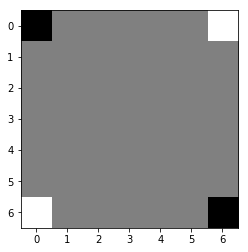

predicted prob for this move is: 0.0500829
0.1


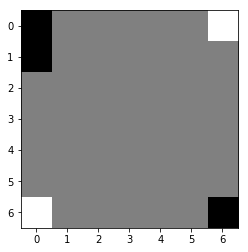

predicted prob for this move is: 0.0558142
0.0


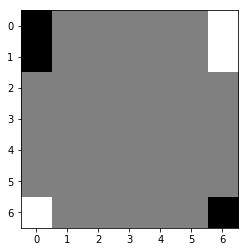

predicted prob for this move is: 0.0498745
0.1


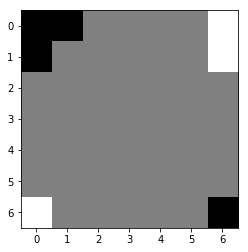

predicted prob for this move is: 0.0548273
0.1


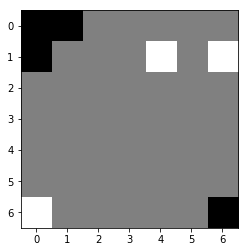

predicted prob for this move is: 0.0489075
0.1


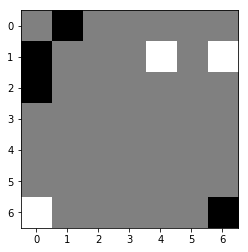

predicted prob for this move is: 0.0471036
0.0


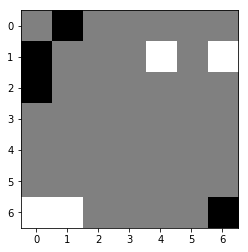

predicted prob for this move is: 0.0476723
0.0


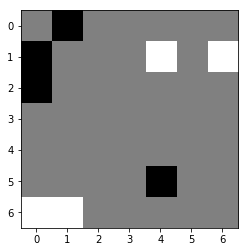

predicted prob for this move is: 0.0458966
-0.1


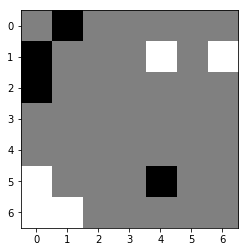

predicted prob for this move is: 0.0454435
0.0


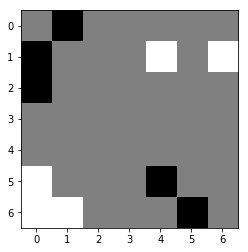

predicted prob for this move is: 0.0456216
0.0


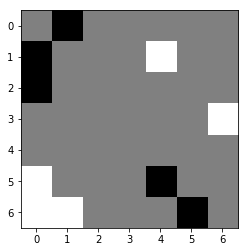

predicted prob for this move is: 0.0451018
0.1


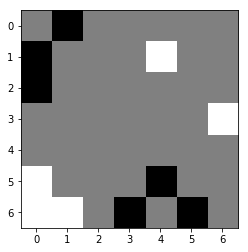

predicted prob for this move is: 0.0513063
-0.2


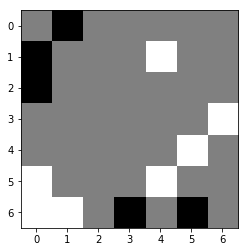

predicted prob for this move is: 0.0494812
0.2


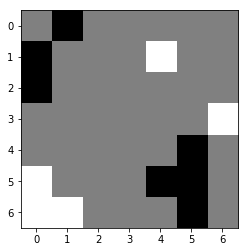

predicted prob for this move is: 0.0511965
0.2


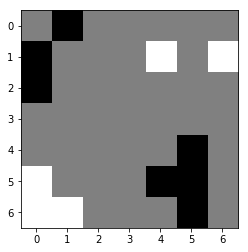

predicted prob for this move is: 0.0452206
0.4


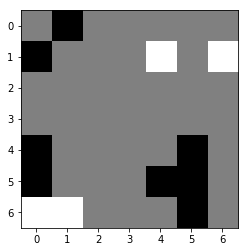

predicted prob for this move is: 0.045478
0.2


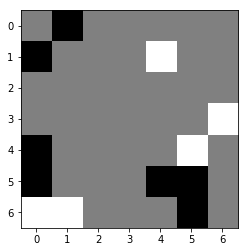

predicted prob for this move is: 0.045167
0.30000000000000004


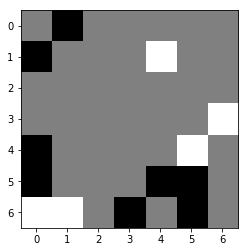

predicted prob for this move is: 0.0520244
0.30000000000000004


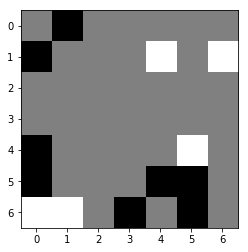

predicted prob for this move is: 0.0451818
0.5


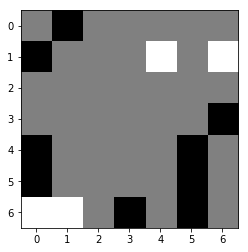

predicted prob for this move is: 0.044366
0.4


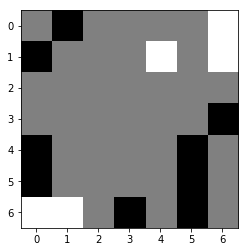

predicted prob for this move is: 0.0524935
0.4


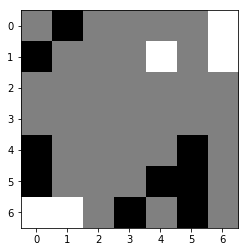

predicted prob for this move is: 0.0517958
0.4


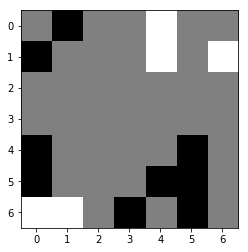

predicted prob for this move is: 0.0450258
0.4


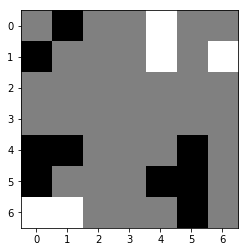

predicted prob for this move is: 0.0455064
0.2


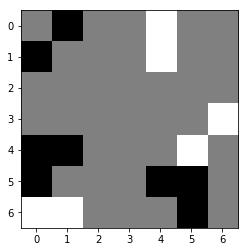

predicted prob for this move is: 0.0471584
0.2


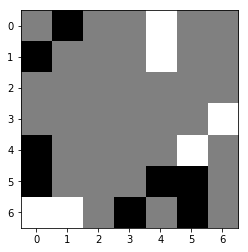

predicted prob for this move is: 0.0518738
0.2


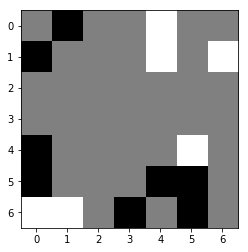

predicted prob for this move is: 0.0449844
0.4


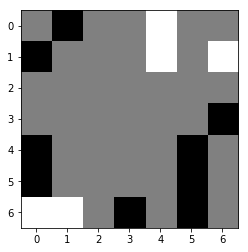

predicted prob for this move is: 0.0443106
0.30000000000000004


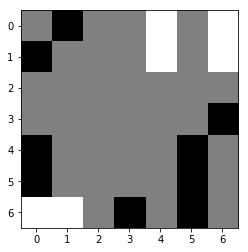

predicted prob for this move is: 0.052523
0.30000000000000004


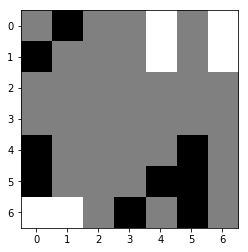

predicted prob for this move is: 0.0516851
0.2


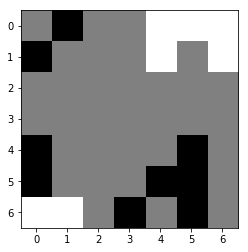

predicted prob for this move is: 0.0452735
0.2


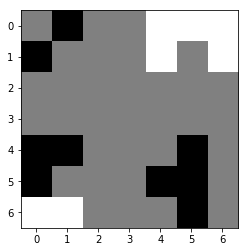

predicted prob for this move is: 0.0515934
0.1


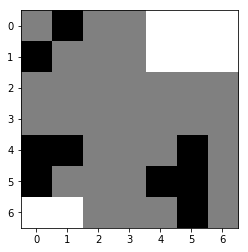

predicted prob for this move is: 0.0468667
0.1


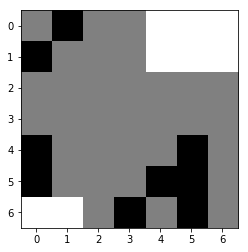

predicted prob for this move is: 0.051377
0.1


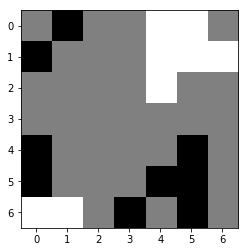

predicted prob for this move is: 0.045531
0.1


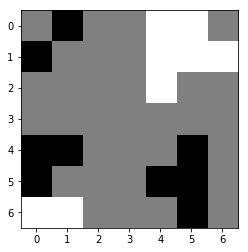

predicted prob for this move is: 0.0475758
-0.1


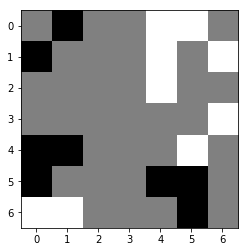

predicted prob for this move is: 0.0473653
-0.1


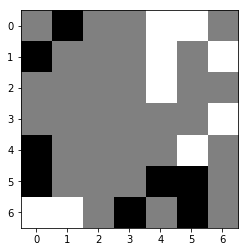

predicted prob for this move is: 0.0482066
-0.4


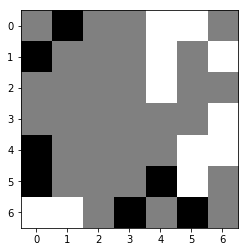

predicted prob for this move is: 0.0454704
-0.4


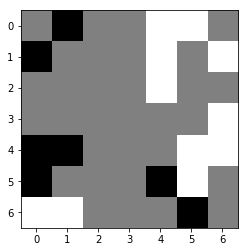

predicted prob for this move is: 0.0469408
-0.4


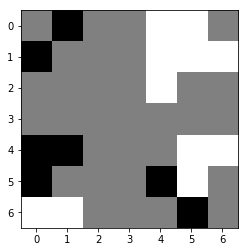

predicted prob for this move is: 0.0475061
-0.4


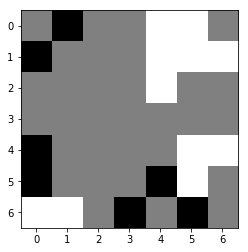

predicted prob for this move is: 0.0490313
-0.5


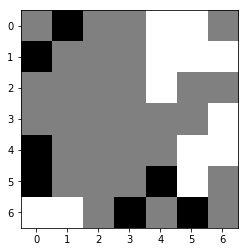

predicted prob for this move is: 0.045519
-0.5


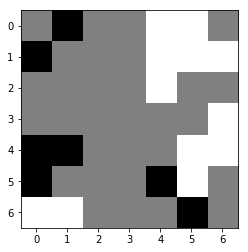

predicted prob for this move is: 0.0469633
-0.6000000000000001


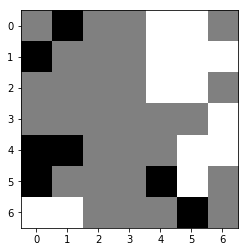

predicted prob for this move is: 0.0478689
-0.6000000000000001


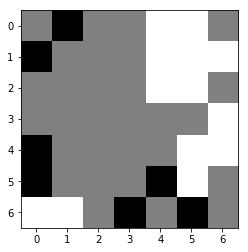

predicted prob for this move is: 0.0472405
-0.7000000000000001


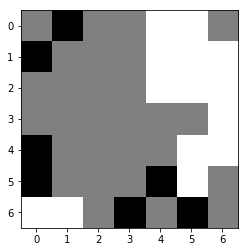

predicted prob for this move is: 0.0454718
-0.7000000000000001


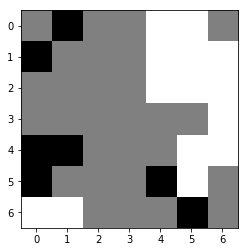

predicted prob for this move is: 0.0469123
-0.7000000000000001


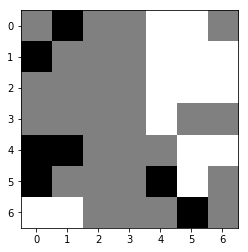

predicted prob for this move is: 0.0475751
-0.7000000000000001


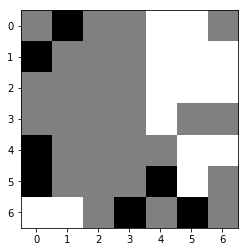

predicted prob for this move is: 0.0483103
-0.8


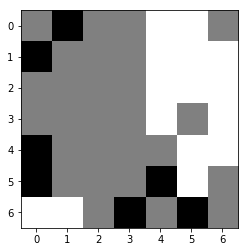

predicted prob for this move is: 0.0451428
-0.8


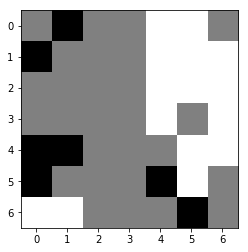

predicted prob for this move is: 0.0469115
-0.9


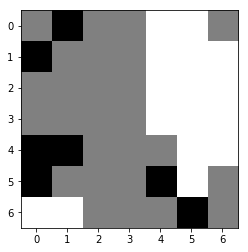

predicted prob for this move is: 0.0476096
-0.9


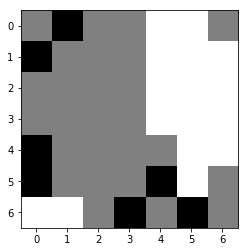

predicted prob for this move is: 0.0471272
-1.1


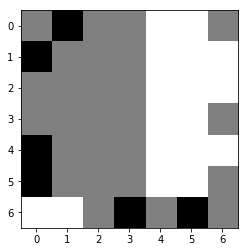

predicted prob for this move is: 0.0447652
-1.1


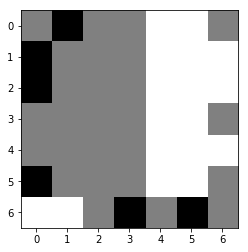

predicted prob for this move is: 0.0487925
-1.1


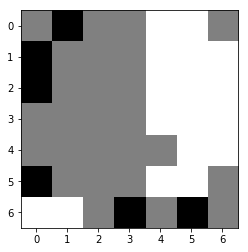

predicted prob for this move is: 0.0454612
-1.1


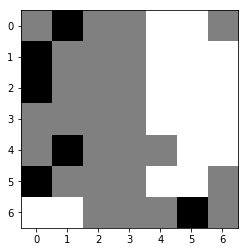

predicted prob for this move is: 0.0463765
-1.1


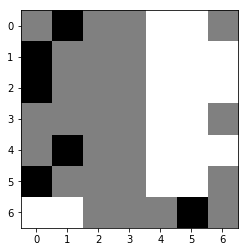

predicted prob for this move is: 0.0470932
-0.9


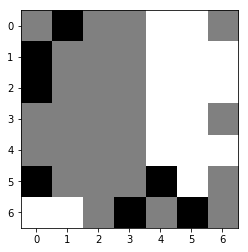

predicted prob for this move is: 0.0484891
-0.9


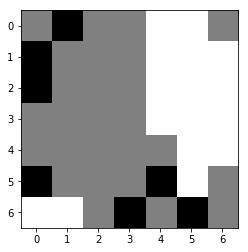

predicted prob for this move is: 0.0453702
-0.9


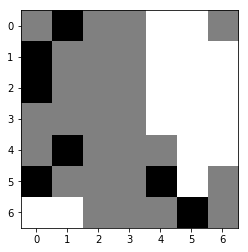

predicted prob for this move is: 0.0469161
-1.1


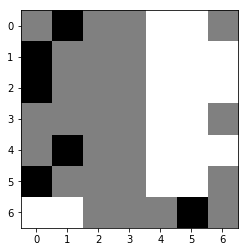

predicted prob for this move is: 0.0470932
-0.9


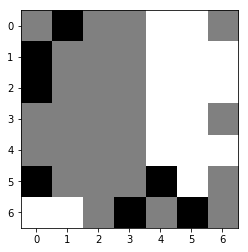

predicted prob for this move is: 0.0484891
-0.9


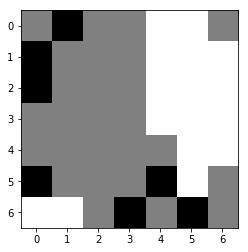

predicted prob for this move is: 0.0453702
-0.9


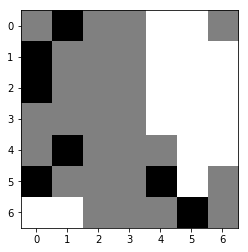

predicted prob for this move is: 0.0469161
-1.1


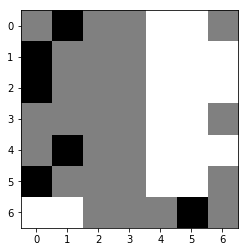

predicted prob for this move is: 0.0470932
-0.9


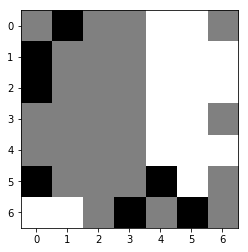

predicted prob for this move is: 0.0484891
-0.9


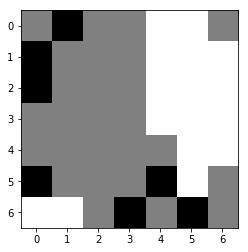

predicted prob for this move is: 0.0453702
-0.9


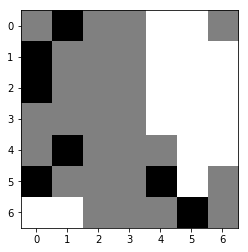

predicted prob for this move is: 0.0469161
-1.1


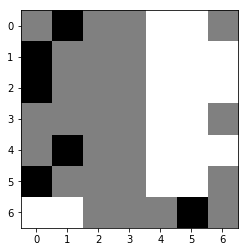

predicted prob for this move is: 0.0470932
-0.9


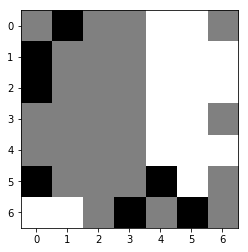

predicted prob for this move is: 0.0484891
-0.9


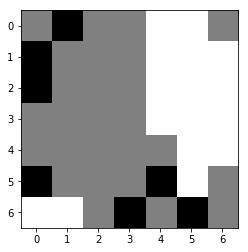

predicted prob for this move is: 0.0453702
-0.9


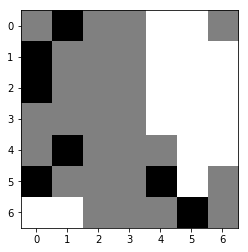

predicted prob for this move is: 0.0469161
-1.1


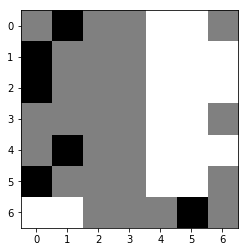

predicted prob for this move is: 0.0470932
-0.9


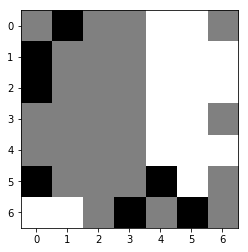

predicted prob for this move is: 0.0484891
-0.9


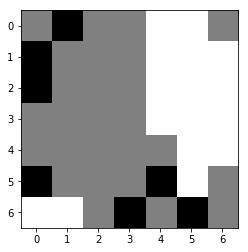

predicted prob for this move is: 0.0453702
-0.9


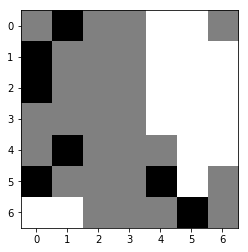

predicted prob for this move is: 0.0469161
-1.1


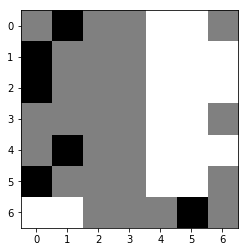

predicted prob for this move is: 0.0470932
-0.9


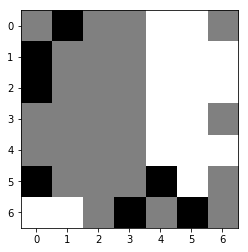

predicted prob for this move is: 0.0484891
-0.9


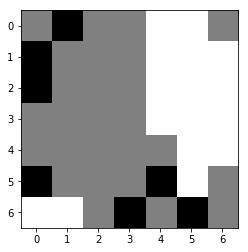

predicted prob for this move is: 0.0453702
-0.9


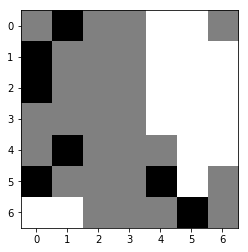

predicted prob for this move is: 0.0469161
-1.1


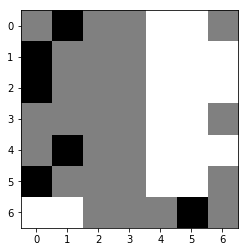

predicted prob for this move is: 0.0470932
-0.9


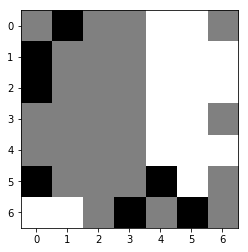

predicted prob for this move is: 0.0484891
-0.9


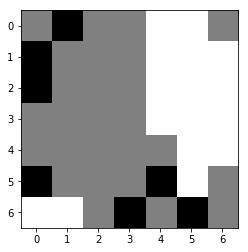

predicted prob for this move is: 0.0453702
-0.9


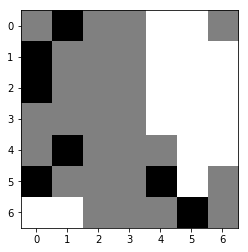

predicted prob for this move is: 0.0469161
-1.1


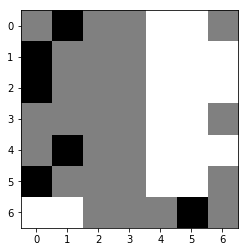

predicted prob for this move is: 0.0470932
-0.9


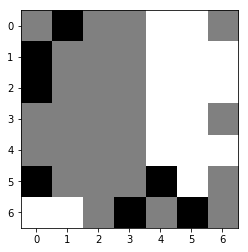

predicted prob for this move is: 0.0484891
-0.9


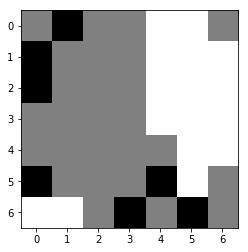

predicted prob for this move is: 0.0453702
-0.9


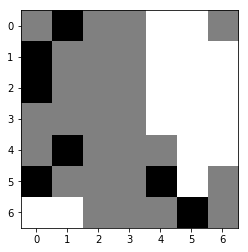

predicted prob for this move is: 0.0469161
-1.1


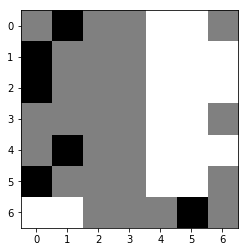

predicted prob for this move is: 0.0470932
-0.9


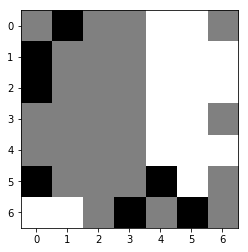

predicted prob for this move is: 0.0484891
-0.9


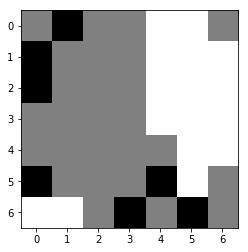

predicted prob for this move is: 0.0453702
-0.9


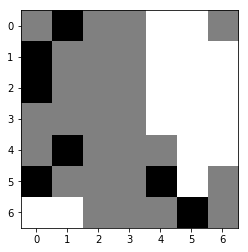

predicted prob for this move is: 0.0469161
-1.1


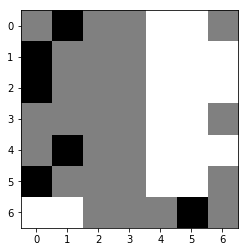

predicted prob for this move is: 0.0470932
-0.9


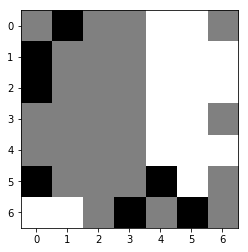

predicted prob for this move is: 0.0484891
-0.9


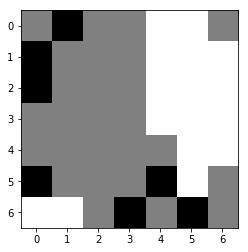

predicted prob for this move is: 0.0453702
-0.9


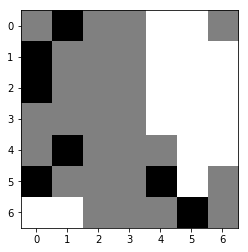

predicted prob for this move is: 0.0469161
-1.1


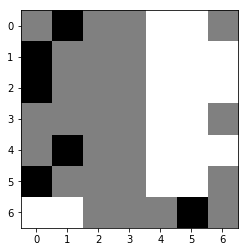

predicted prob for this move is: 0.0470932
-0.9


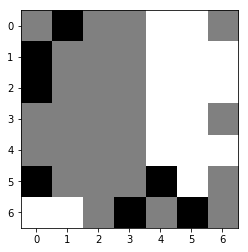

predicted prob for this move is: 0.0484891
-0.9


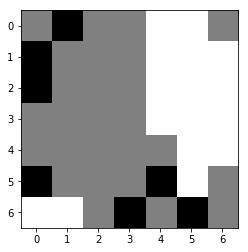

predicted prob for this move is: 0.0453702
-0.9


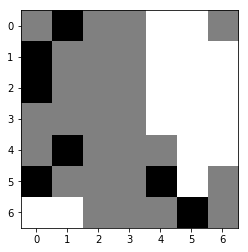

predicted prob for this move is: 0.0469161
-1.1


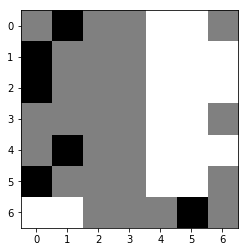

predicted prob for this move is: 0.0470932
-0.9


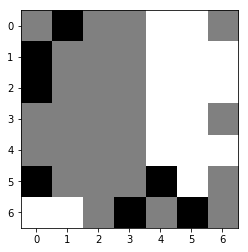

predicted prob for this move is: 0.0484891
-0.9


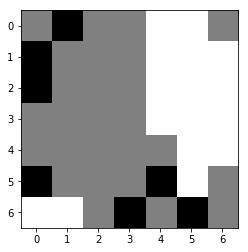

predicted prob for this move is: 0.0453702
-0.9


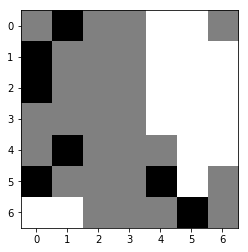

predicted prob for this move is: 0.0469161
-1.1


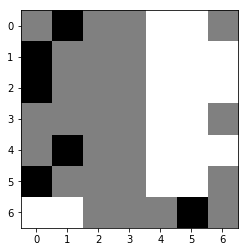

predicted prob for this move is: 0.0470932
-0.9


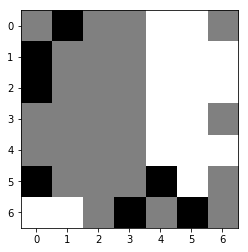

predicted prob for this move is: 0.0484891
-0.9


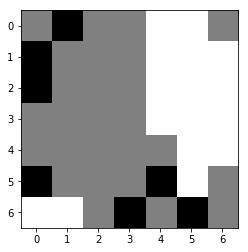

predicted prob for this move is: 0.0453702
-0.9


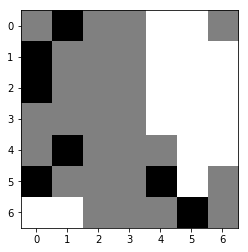

predicted prob for this move is: 0.0469161
-1.1


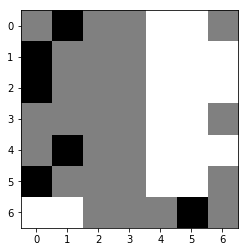

predicted prob for this move is: 0.0470932
-0.9


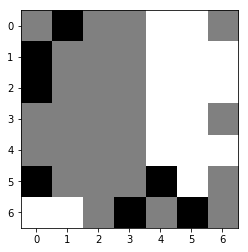

predicted prob for this move is: 0.0484891
-0.9


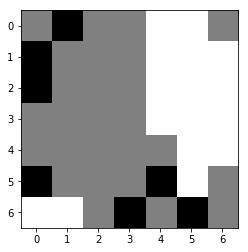

predicted prob for this move is: 0.0453702
-0.9


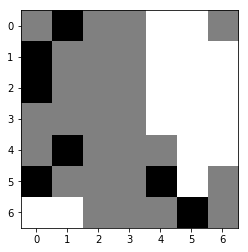

predicted prob for this move is: 0.0469161
-1.1


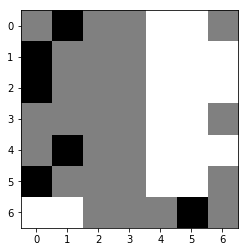

predicted prob for this move is: 0.0470932
-0.9


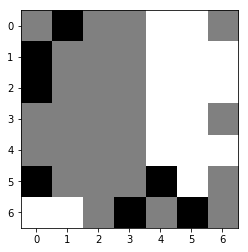

predicted prob for this move is: 0.0484891
-0.9


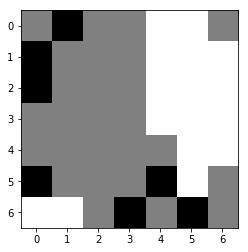

predicted prob for this move is: 0.0453702
-0.9


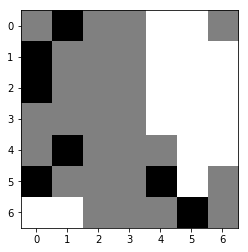

predicted prob for this move is: 0.0469161
-1.1


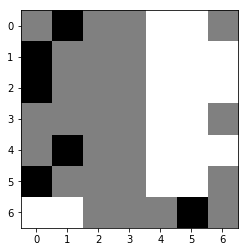

predicted prob for this move is: 0.0470932
-0.9


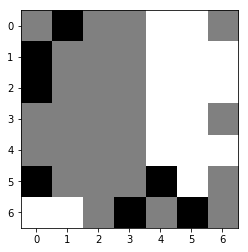

predicted prob for this move is: 0.0484891
-0.9


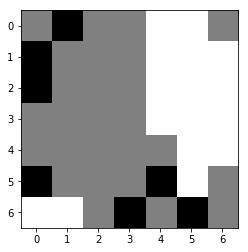

predicted prob for this move is: 0.0453702
-0.9


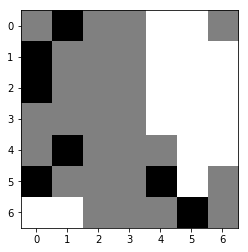

predicted prob for this move is: 0.0469161
-1.1


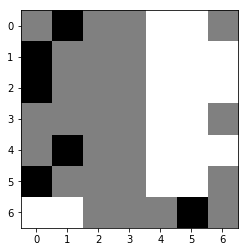

predicted prob for this move is: 0.0470932
-0.9


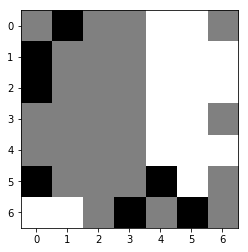

predicted prob for this move is: 0.0484891
-0.9


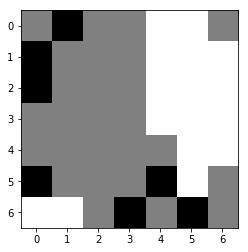

predicted prob for this move is: 0.0453702
-0.9


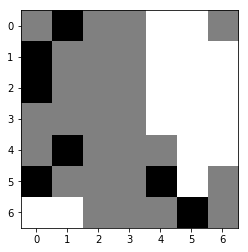

predicted prob for this move is: 0.0469161
-1.1


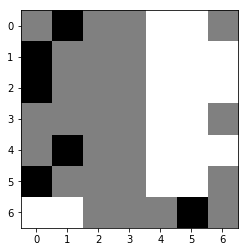

predicted prob for this move is: 0.0470932
-0.9


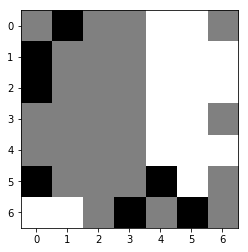

predicted prob for this move is: 0.0484891
-0.9


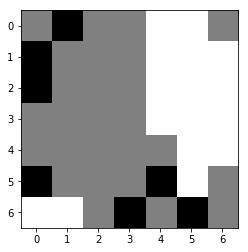

predicted prob for this move is: 0.0453702
-0.9


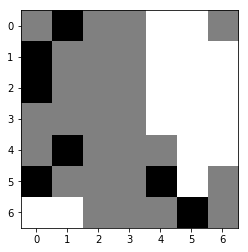

predicted prob for this move is: 0.0469161
-1.1


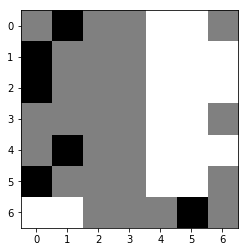

predicted prob for this move is: 0.0470932
-0.9


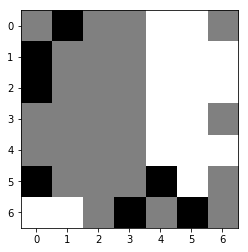

predicted prob for this move is: 0.0484891
-0.9


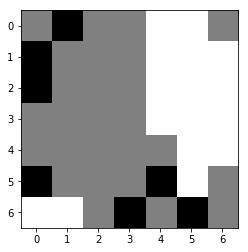

predicted prob for this move is: 0.0453702
-0.9


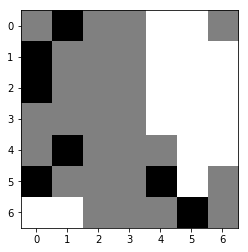

predicted prob for this move is: 0.0469161
-1.1


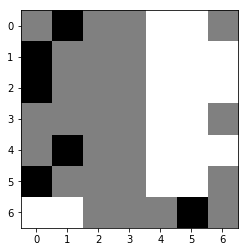

predicted prob for this move is: 0.0470932
-0.9


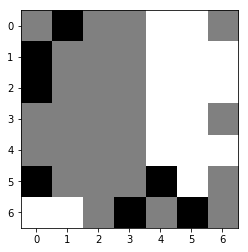

predicted prob for this move is: 0.0484891
-0.9


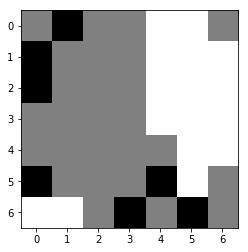

predicted prob for this move is: 0.0453702
-0.9


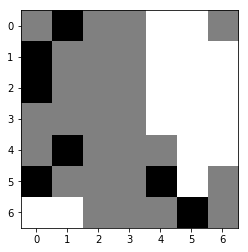

predicted prob for this move is: 0.0469161
-1.1


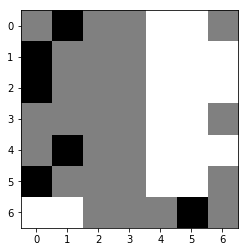

predicted prob for this move is: 0.0470932
-0.9


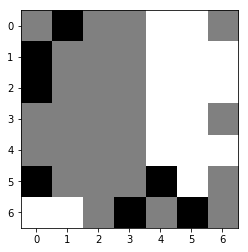

predicted prob for this move is: 0.0484891
-0.9


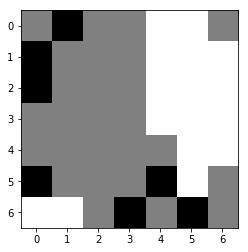

predicted prob for this move is: 0.0453702
-0.9


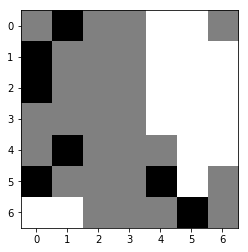

predicted prob for this move is: 0.0469161
-1.1


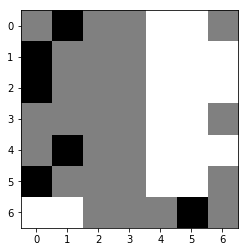

predicted prob for this move is: 0.0470932
-0.9


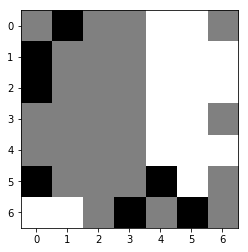

predicted prob for this move is: 0.0484891
-0.9


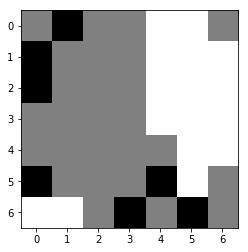

predicted prob for this move is: 0.0453702
-0.9


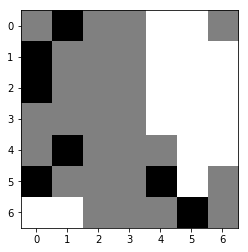

predicted prob for this move is: 0.0469161
-1.1


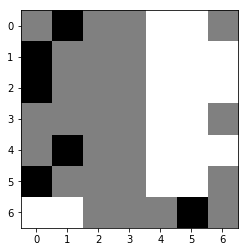

predicted prob for this move is: 0.0470932
-0.9


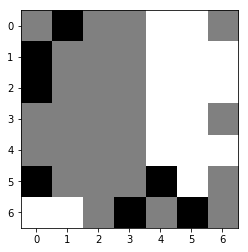

predicted prob for this move is: 0.0484891
-0.9


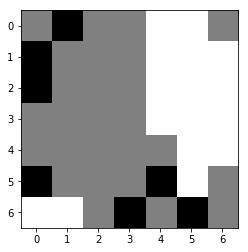

predicted prob for this move is: 0.0453702
-0.9


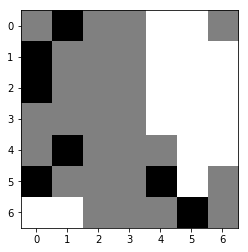

predicted prob for this move is: 0.0469161
-1.1


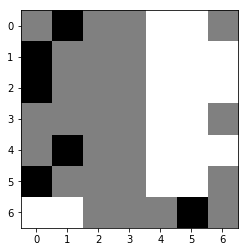

predicted prob for this move is: 0.0470932
-0.9


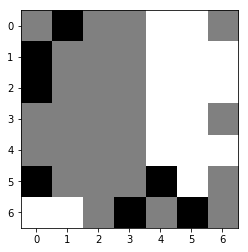

predicted prob for this move is: 0.0484891
-0.9


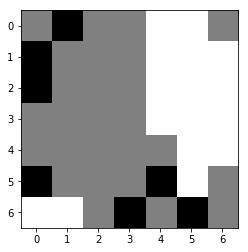

predicted prob for this move is: 0.0453702
-0.9


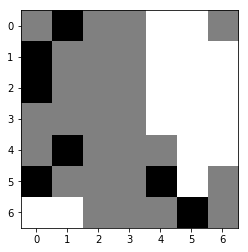

predicted prob for this move is: 0.0469161
-1.1


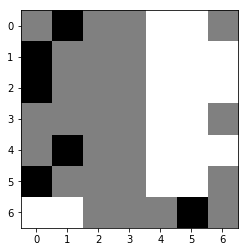

predicted prob for this move is: 0.0470932
-0.9


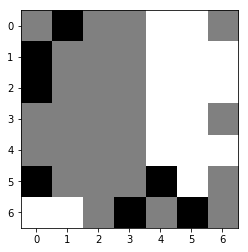

predicted prob for this move is: 0.0484891
-0.9


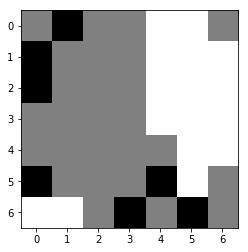

predicted prob for this move is: 0.0453702
-0.9


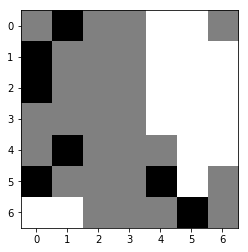

predicted prob for this move is: 0.0469161
-1.1


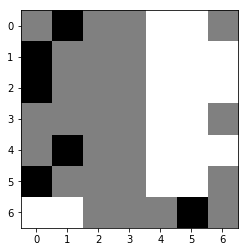

predicted prob for this move is: 0.0470932
-0.9


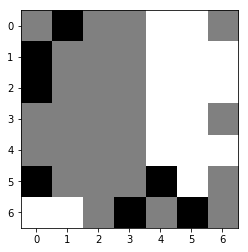

predicted prob for this move is: 0.0484891
-0.9


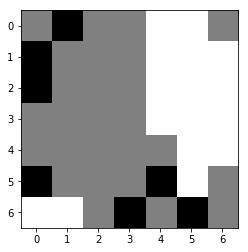

predicted prob for this move is: 0.0453702
-0.9


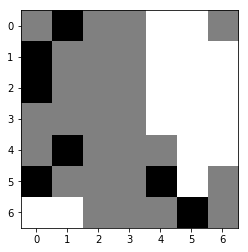

predicted prob for this move is: 0.0469161
-1.1


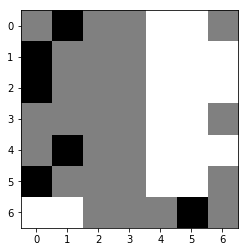

predicted prob for this move is: 0.0470932
-0.9


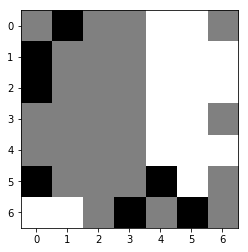

predicted prob for this move is: 0.0484891
-0.9


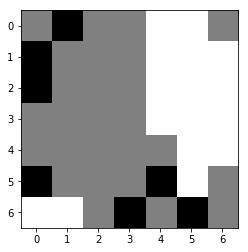

predicted prob for this move is: 0.0453702
-0.9


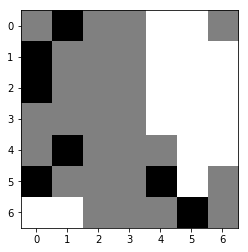

predicted prob for this move is: 0.0469161
-1.1


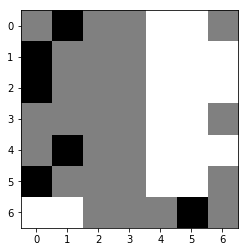

predicted prob for this move is: 0.0470932
-0.9


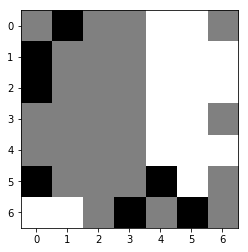

predicted prob for this move is: 0.0484891
-0.9


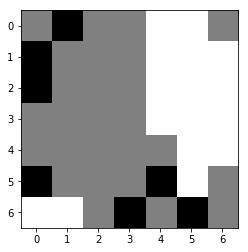

predicted prob for this move is: 0.0453702
-0.9


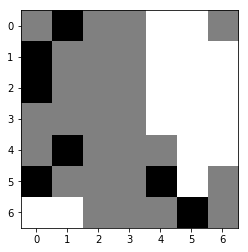

predicted prob for this move is: 0.0469161
-1.1


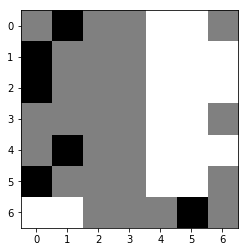

predicted prob for this move is: 0.0470932
-0.9


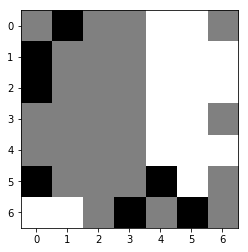

predicted prob for this move is: 0.0484891
-0.9


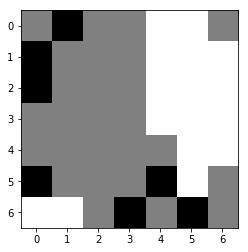

predicted prob for this move is: 0.0453702
-0.9


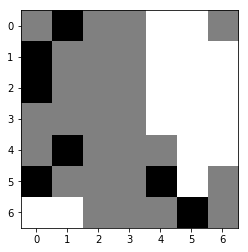

predicted prob for this move is: 0.0469161
-1.1


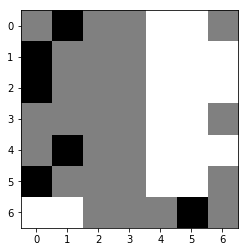

predicted prob for this move is: 0.0470932
-0.9


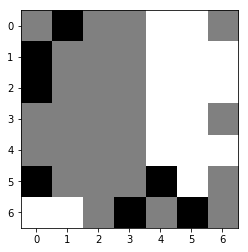

predicted prob for this move is: 0.0484891
-0.9


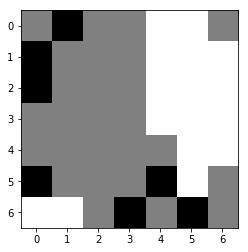

predicted prob for this move is: 0.0453702
-0.9


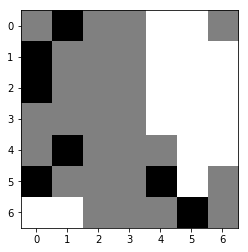

predicted prob for this move is: 0.0469161
-1.1


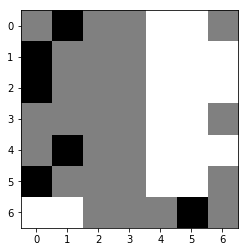

predicted prob for this move is: 0.0470932
-0.9


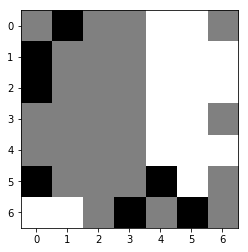

predicted prob for this move is: 0.0484891
-0.9


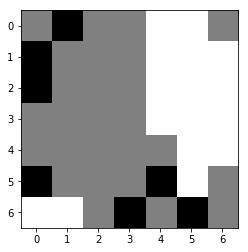

predicted prob for this move is: 0.0453702
-0.9


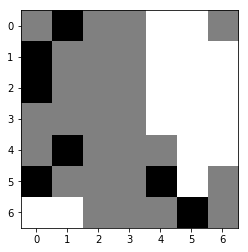

predicted prob for this move is: 0.0469161
-1.1


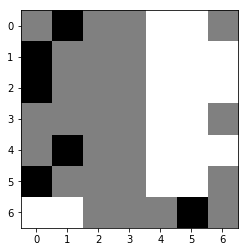

predicted prob for this move is: 0.0470932
-0.9


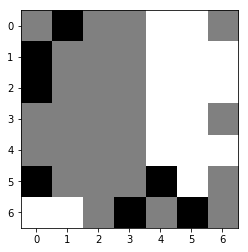

predicted prob for this move is: 0.0484891
-0.9


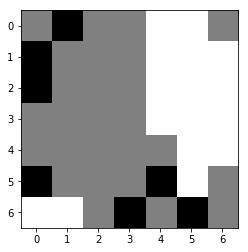

predicted prob for this move is: 0.0453702
-0.9


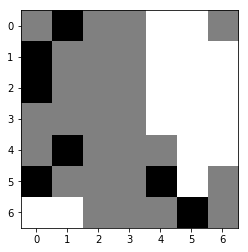

predicted prob for this move is: 0.0469161


KeyboardInterrupt: 

In [28]:
game = Ataxx()
turn = -1
print("-1 is actor")
while abs(game.evaluate(turn, turn)) != 100:
    print(game.evaluate(-1, turn))
    game.plot()
    pos0, pos1, _ = actor.get_noised_action(game, turn, 0, is_target=True)
    game.move_to(turn, pos0, pos1)
    turn = -turn
    time.sleep(0.1)
print(game.evaluate(-1, turn))

1 is actor
0.0


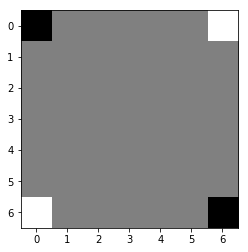

0.1


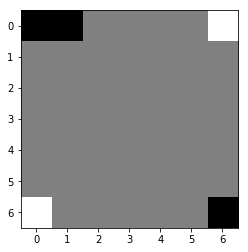

predicted prob for this move is: 0.239719
0.1


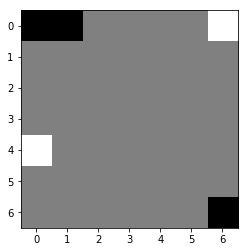

0.2


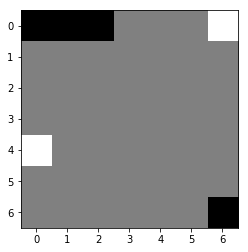

predicted prob for this move is: 0.410743
0.2


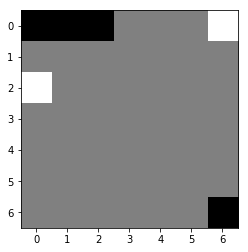

0.5


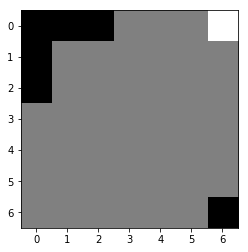

predicted prob for this move is: 0.166497
0.5


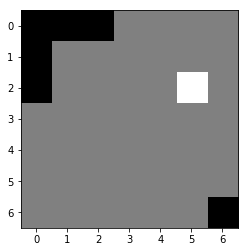

100


In [9]:
game = Ataxx()
turn = -1
print("1 is actor")
while abs(game.evaluate(turn, turn)) != 100:
    print(game.evaluate(-1, turn))
    game.plot()
    if turn == -1:
        best_move = game.get_greedy_move(turn)
        game.move_to(turn, best_move[0], best_move[1])
    else:
        pos0, pos1, _ = actor.get_noised_action(game, turn, 0, is_target=True)
        game.move_to(turn, pos0, pos1)
    turn = -turn
    time.sleep(0.1)
print(game.evaluate(-1, turn))

-1 is actor
0.0


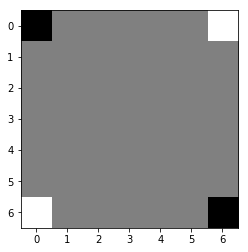

predicted prob for this move is: 0.0500829
0.1


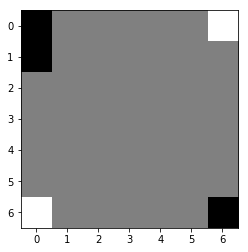

0.0


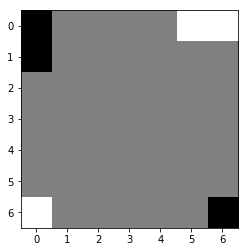

predicted prob for this move is: 0.0497656
0.1


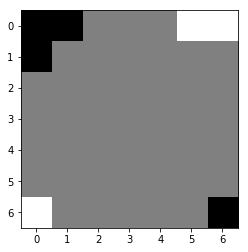

0.0


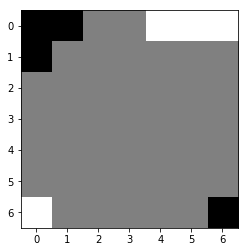

predicted prob for this move is: 0.0490917
0.0


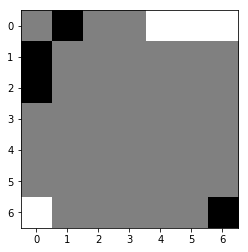

-0.2


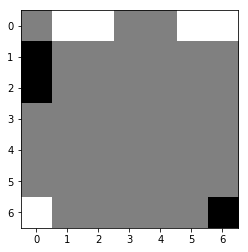

predicted prob for this move is: 0.0481683
-0.2


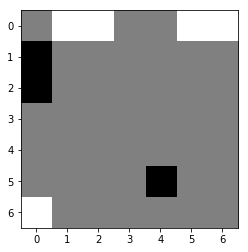

-0.7000000000000001


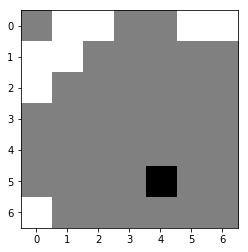

predicted prob for this move is: 0.0457362
-0.6000000000000001


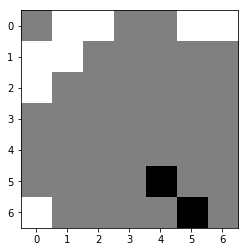

-0.7000000000000001


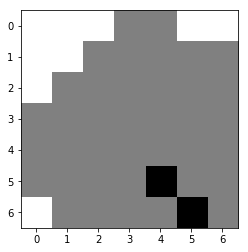

predicted prob for this move is: 0.0453432
-0.7000000000000001


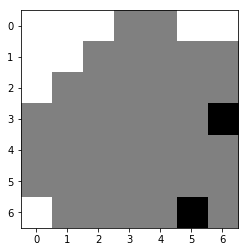

-0.9


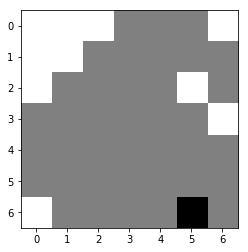

predicted prob for this move is: 0.0476256
-0.8


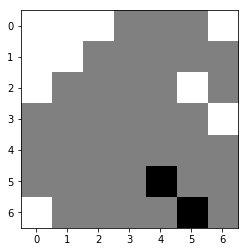

-100


In [29]:
game = Ataxx()
turn = -1
print("-1 is actor")
while abs(game.evaluate(turn, turn)) != 100:
    print(game.evaluate(-1, turn))
    game.plot()
    if turn == 1:
        best_move = game.get_greedy_move(turn)
        game.move_to(turn, best_move[0], best_move[1])
    else:
        pos0, pos1, _ = actor.get_noised_action(game, turn, 0, is_target=True)
        game.move_to(turn, pos0, pos1)
    turn = -turn
    time.sleep(0.1)
print(game.evaluate(-1, turn))

In [50]:
graph = 0

def reinforcement_data_generator(actor_model, actor_target, critic_model, critic_target, relay, \
                                 train_critic=True, step_per_episode=50, \
                                 BATCH_SIZE=64, GAMMA=0.99, RELAY_SIZE=10000): 
    global graph
    with graph.as_default():
        max_score = 1
        min_score = 0.02
        policy_mask_init = 0.01

        actor = ActorNetwork(target_model=actor_target, model=actor_model)
        critic = CriticNetwork(target_model=critic_target, model=actor_model)
        print("actor critic prepared")

        while True:
            reward = 0
            step = 0

            game = Ataxx()
            turn = -1 # start turn is -1

            while abs(game.evaluate(turn, turn, max_score, min_score)) != max_score:
                new_sample = [] # prepare to collect new sample

                pos0, pos1, cur_action_mask = actor.get_noised_action(game, turn, epsilon=0.1, mask_init=policy_mask_init, verbose=0) # get proposed action

                new_state = game.simu_move_to(turn, pos0, pos1)

                # create new_sample and add that to relay
                new_sample.append(game.get_feature_map(turn)) # cur_state
                new_sample.append(game.get_mask(turn)) # cur_mask
                new_sample.append(actor.get_action_prob(game, turn)) # cur_action
                new_sample.append(cur_action_mask) # cur_action_mask

                game.move_to(turn, pos0, pos1) # do the move here if the move is valid
                turn = -turn # the turn now is the next turn, what we are learning for is -turn

                new_sample.append(game.evaluate(-turn, turn, max_score, min_score)) # cur_reward
                if abs(new_sample[-1]) == max_score:
                    new_sample.append(None) 
                else:
                    new_sample.append(game.get_feature_map(turn)) # new_state

                relay.add_sample(new_sample)

            if relay.size() > BATCH_SIZE:
                for t in range(step_per_episode):
                    cur_state, cur_mask, cur_action, cur_action_mask, \
                        cur_reward, new_state = relay.get_batch(BATCH_SIZE)
                    q_target = np.zeros(BATCH_SIZE)

                    for k in range(BATCH_SIZE):
                        if new_state[k] is None:
                            q_target[k] = cur_reward[k]
                        else:
                            # generate new action
                            board = new_state[k][0] - new_state[k][1]
                            tmp_game = Ataxx(board) # recover the game board

                            new_action, new_action_mask = actor.get_noised_action(tmp_game, 1, epsilon=0, return_position=False, 
                                                                        mask_init=policy_mask_init, is_target=True, verbose=False)
                            q_new = critic.target_model.predict([new_state[k].reshape(1, 2, 7, 7), 
                                                                new_action.reshape(1, 2, 7, 7),
                                                                new_action_mask.reshape(1, 2, 7, 7)])[0]
                            q_target[k] = cur_reward[k] - GAMMA*q_new # cuz this q_new is for the opponent
                    if train_critic:
                        yield [cur_state, cur_action, cur_action_mask], q_target
                    else:
                        yield [cur_state, cur_mask, cur_action_mask], np.zeros(BATCH_SIZE)

def actor_critic_trainer(epochs=1000, check_point=True, steps_per_epoch=50, \
                           BATCH_SIZE=64, TRAIN_BATCH_TIME=1, GAMMA=0.99, RELAY_SIZE=10000, TAU=0.001, LRA=0.0001, LRC=0.0001): 
    actor = ActorNetwork(TAU, LRA, 0)
    critic = CriticNetwork(TAU, LRC)
    relay = Relay(RELAY_SIZE)
    global graph
    graph = tf.get_default_graph()

    with tf.device('/cpu'):
        actor_critic_model = Model(inputs=[actor.model.inputs[0], actor.model.inputs[1], critic.frozen_model.inputs[2]],
                                   outputs=[critic.frozen_model([actor.model.inputs[0], actor.model.outputs[0], critic.frozen_model.inputs[2]])])
        sgd = SGD(lr=LRA, decay=5e-7, momentum=0.9, nesterov=True)
        actor_critic_model.compile(loss=neg_linear_loss, optimizer=sgd)
    gpu_ac_model = multi_gpu_model(actor_critic_model, gpus=4)
    gpu_ac_model.compile(loss=neg_linear_loss, optimizer=Adam(lr=LRA))
    print(gpu_ac_model.summary())
    
    for ep in range(epochs):
        critic.gpu_model.fit_generator(reinforcement_data_generator(actor.model, actor.target_model, \
                                                                    critic.model, critic.target_model, \
                                                                    relay, train_critic=True, \
                                                                    step_per_episode=50, \
                                                                    BATCH_SIZE=256, GAMMA=0.99, RELAY_SIZE=RELAY_SIZE),\
                                       verbose=1, steps_per_epoch=steps_per_epoch, \
                                       #workers=8, use_multiprocessing=True
                                      )
        gpu_ac_model.fit_generator(reinforcement_data_generator(actor.model, actor.target_model, \
                                                                critic.model, critic.target_model, \
                                                                relay, train_critic=False, \
                                                                step_per_episode=50, \
                                                                BATCH_SIZE=256, GAMMA=0.99, RELAY_SIZE=RELAY_SIZE),\
                                   verbose=1, steps_per_epoch=steps_per_epoch, \
                                   #workers=8, use_multiprocessing=True
                                  )
        actor.target_train()
        critic.target_train()
        
        if check_point:
            actor.save()
        tmp_game = Ataxx()
        print("trained action prob map predicted by initial model for a starting game")
        print(actor.get_action_prob(tmp_game, -1, is_target=True))

In [51]:
actor_critic_trainer(epochs=1000, check_point=True, steps_per_epoch=50, \
                     BATCH_SIZE=64, TRAIN_BATCH_TIME=1, GAMMA=0.99, RELAY_SIZE=10000, \
                     TAU=0.001, LRA=0.0001, LRC=0.0001) 
    

/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:121: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_153 (InputLayer)          (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
conv2d_242 (Conv2D)             (None, 64, 5, 5)     1216        input_153[0][0]                  
__________________________________________________________________________________________________
batch_normalization_271 (BatchN (None, 64, 5, 5)     256         conv2d_242[0][0]                 
__________________________________________________________________________________________________
conv2d_243 (Conv2D)             (None, 64, 5, 5)     36928       batch_normalization_271[0][0]    
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_161 (InputLayer)          (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
input_162 (InputLayer)          (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
multiply_64 (Multiply)          (None, 2, 7, 7)      0           input_161[0][0]                  
                                                                 input_162[0][0]                  
__________________________________________________________________________________________________
input_160 (InputLayer)          (None, 2, 7, 7)      0                                            
__________

50/50 [==============================] - 127s 3s/step - loss: 1.9434 - mean_squared_error: 1.9434


Exception ignored in: <generator object reinforcement_data_generator at 0x7f765f58e468>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 117s 2s/step - loss: -1.4782e-08


Exception ignored in: <generator object reinforcement_data_generator at 0x7f765f58e468>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.02041597]]

 [[ 0.02040417  0.02040417  0.02040417  0.02040417  0.02040417  0.02040417
    0.02040417]
  [ 0.02042603  0.02042381  0.02041361  0.02040417  0.02040417  0.02040417
    0.02040417]
  [ 0.02040417  0.02042197  0.02040417  0.02040417  0.02040417  0.02040417
    0.02040417]
  [ 0.02040417  0.02040417  0.0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 108s 2s/step - loss: -3.7905e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.0204167 ]]

 [[ 0.02040579  0.02040579  0.0204107   0.02040579  0.02040579  0.02040579
    0.02040579]
  [ 0.020414    0.02040579  0.02042309  0.02040579  0.02040579  0.02040579
    0.02040579]
  [ 0.02040579  0.02040579  0.02040579  0.02040579  0.02040579  0.02040579
    0.02040579]
  [ 0.02040579  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 107s 2s/step - loss: 1.4529e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02041829]]

 [[ 0.02040545  0.02040545  0.02043251  0.02040545  0.02040545  0.02040545
    0.02040545]
  [ 0.02040545  0.02040545  0.02042651  0.02040545  0.02040545  0.02040545
    0.02040545]
  [ 0.02040545  0.02040545  0.02040961  0.02040545  0.02040545  0.02040545
    0.02040545]
  [ 0.02040545  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 106s 2s/step - loss: -7.9488e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02041747]]

 [[ 0.02040438  0.02040438  0.02045121  0.02040438  0.02040438  0.02040438
    0.02040438]
  [ 0.02040438  0.02040438  0.02042737  0.02040438  0.02040438  0.02040438
    0.02040438]
  [ 0.02040438  0.02040438  0.02041601  0.02040438  0.02040438  0.02040438
    0.02040438]
  [ 0.02040438  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 106s 2s/step - loss: 1.4668e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02041208]]

 [[ 0.02040343  0.02040343  0.0204699   0.02040343  0.02040343  0.02040343
    0.02040343]
  [ 0.02040343  0.02040343  0.02042824  0.02040343  0.02040343  0.02040343
    0.02040343]
  [ 0.02040343  0.02040343  0.02042096  0.02040343  0.02040343  0.02040343
    0.02040343]
  [ 0.02040343  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 105s 2s/step - loss: -6.9197e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02041005  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]]

 [[ 0.02040233  0.02040233  0.02048798  0.02040233  0.02040233  0.02040233
    0.02040233]
  [ 0.02040233  0.02040233  0.02042876  0.02040233  0.02040233  0.02040233
    0.02040233]
  [ 0.02040233  0.02040233  0.02042454  0.02040233  0.02040233  0.02040233
    0.02040233]
  [ 0.02040233  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 105s 2s/step - loss: -9.8068e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02041354  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]]

 [[ 0.02040141  0.02040141  0.02050594  0.02040141  0.02040141  0.02040141
    0.02040141]
  [ 0.02040141  0.02040141  0.02043002  0.02040141  0.02040141  0.02040141
    0.02040141]
  [ 0.02040141  0.02040141  0.02042576  0.02040141  0.02040141  0.02040141
    0.02040141]
  [ 0.02040141  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 104s 2s/step - loss: -3.1758e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02041675  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]]

 [[ 0.02040056  0.02040056  0.02052318  0.02040056  0.02040056  0.02040056
    0.02040056]
  [ 0.02040056  0.02040056  0.02043022  0.02040056  0.02040056  0.02040056
    0.02040056]
  [ 0.02040056  0.02040056  0.02042694  0.02040056  0.02040056  0.02040056
    0.02040056]
  [ 0.02040056  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 105s 2s/step - loss: 1.5972e-08


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02041998  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]]

 [[ 0.02039975  0.02039975  0.02053815  0.02039975  0.02039975  0.02039975
    0.02039975]
  [ 0.02039975  0.02039975  0.02043092  0.02039975  0.02039975  0.02039975
    0.02039975]
  [ 0.02039975  0.02039975  0.02042914  0.02039975  0.02039975  0.02039975
    0.02039975]
  [ 0.02039975  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 104s 2s/step - loss: -2.9756e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.0204231   0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]]

 [[ 0.02039894  0.02040579  0.0205518   0.02039894  0.02039894  0.02039894
    0.02039894]
  [ 0.02039894  0.02039894  0.02043077  0.02039894  0.02039894  0.02039894
    0.02039894]
  [ 0.02039894  0.02039894  0.02042754  0.02039894  0.02039894  0.02039894
    0.02039894]
  [ 0.02039894  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 103s 2s/step - loss: -3.9209e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02042691  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]]

 [[ 0.02039819  0.02041248  0.02056349  0.02039819  0.02039819  0.02039819
    0.02039819]
  [ 0.02039819  0.02039819  0.0204301   0.02039819  0.02039819  0.02039819
    0.02039819]
  [ 0.02039819  0.02039819  0.02042566  0.02039819  0.02039819  0.02039819
    0.02039819]
  [ 0.02039819  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: 3.9442e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.0204308   0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]]

 [[ 0.02039758  0.02041801  0.02057318  0.02039758  0.02039758  0.02039758
    0.02039758]
  [ 0.02039758  0.02039758  0.02042926  0.02039758  0.02039758  0.02039758
    0.02039758]
  [ 0.02039758  0.02039758  0.02042391  0.02039758  0.02039758  0.02039758
    0.02039758]
  [ 0.02039758  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: -1.4156e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02043401  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]]

 [[ 0.02039705  0.02042411  0.02058309  0.02039705  0.02039705  0.02039705
    0.02039705]
  [ 0.02039705  0.02039705  0.02042831  0.02039705  0.02039705  0.02039705
    0.02039705]
  [ 0.02039705  0.02039705  0.02042199  0.02039705  0.02039705  0.02039705
    0.02039705]
  [ 0.02039705  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 103s 2s/step - loss: 6.5193e-10


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02043587  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]]

 [[ 0.02039659  0.02043026  0.020593    0.02039659  0.02039659  0.02039659
    0.02039659]
  [ 0.02039659  0.02039659  0.02042667  0.02039659  0.02039659  0.02039659
    0.02039659]
  [ 0.02039659  0.02039659  0.02042037  0.02039659  0.02039659  0.02039659
    0.02039659]
  [ 0.02039659  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: 5.0245e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.0204375   0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]]

 [[ 0.02039614  0.02043639  0.02060285  0.02039614  0.02039614  0.02039614
    0.02039614]
  [ 0.02039614  0.02039614  0.02042501  0.02039614  0.02039614  0.02039614
    0.02039614]
  [ 0.02039614  0.02039614  0.02041861  0.02039614  0.02039614  0.02039614
    0.02039614]
  [ 0.02039614  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 102s 2s/step - loss: 2.3004e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02043931  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]]

 [[ 0.02039566  0.02044197  0.02061351  0.02039566  0.02039566  0.02039566
    0.02039566]
  [ 0.02039566  0.02039566  0.02042458  0.02039566  0.02039566  0.02039566
    0.02039566]
  [ 0.02039566  0.02039566  0.02041656  0.02039566  0.02039566  0.02039566
    0.02039566]
  [ 0.02039566  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 101s 2s/step - loss: -1.8813e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02044123  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]]

 [[ 0.02039513  0.0204482   0.0206238   0.02039513  0.02039513  0.02039513
    0.02039513]
  [ 0.02039513  0.02039513  0.02042557  0.02039513  0.02039513  0.02039513
    0.02039513]
  [ 0.02039513  0.02039513  0.0204139   0.02039513  0.02039513  0.02039513
    0.02039513]
  [ 0.02039513  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: -3.5949e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.0204425   0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]]

 [[ 0.02039455  0.02045457  0.02063477  0.02039455  0.02039455  0.02039455
    0.02039455]
  [ 0.02039455  0.02039455  0.02042698  0.02039455  0.02039455  0.02039455
    0.02039455]
  [ 0.02039455  0.02039455  0.02041113  0.02039455  0.02039455  0.02039455
    0.02039455]
  [ 0.02039455  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: 7.1246e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02044372  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]]

 [[ 0.02039393  0.02046089  0.02064561  0.02039393  0.02039393  0.02039393
    0.02039393]
  [ 0.02039731  0.02039393  0.02042882  0.02039393  0.02039393  0.02039393
    0.02039393]
  [ 0.02039393  0.02039393  0.02040839  0.02039393  0.02039393  0.02039393
    0.02039393]
  [ 0.02039393  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 101s 2s/step - loss: 4.0047e-10


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02044491  0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]]

 [[ 0.02039324  0.02046709  0.02065576  0.02039324  0.02039324  0.02039324
    0.02039324]
  [ 0.02040218  0.02039324  0.02043024  0.02039324  0.02039324  0.02039324
    0.02039324]
  [ 0.02039324  0.02039324  0.02040604  0.02039324  0.02039324  0.02039324
    0.02039324]
  [ 0.02039324  0.020393

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
49/50 [============================>.] - ETA: 1s - loss: -3.6208e-09

KeyboardInterrupt: 